# Autoencoder - mouse2

This notebook contains code accompanying the SpikeStability package for the autoencoder analysis related to Fig. 5 of the manuscript 'Tracking neural activity from the same cells during the entire adult life of mice'. More detail is provided in autoencoder_analysis_mouse1 file.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from IPython import display
import PIL
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras import layers, losses, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Model
from sklearn.preprocessing import OneHotEncoder
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

import glob
import time

#looking at the latent space 
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

In [3]:
from numpy.random import seed
seed(1)

In [5]:
import umap

In [9]:
import os
os.chdir('..')

# Load Dataset


In [22]:
your_path_to_data_dir = ''

In [24]:
df_all = pd.read_csv(your_path_to_data_dir+'final_dataset_mouse2.csv')
df_postprocess = pd.read_csv(your_path_to_data_dir+'mouse2_postprocess_data_strong.csv')

In [25]:
#outlier data
df_anomaly = pd.read_csv(your_path_to_data_dir+'anomaly_spikes.csv')
X_anomaly = df_anomaly[['t'+str(i) for i in range(1, 31)]].values
labels_anomaly = df_anomaly['label_anomaly'].values

In [32]:
df = df_all

# Model architecture

In [27]:
spike_cols = ['t'+str(i) for i in range(1, 31)]
spikes = df_all[spike_cols].values

In [29]:
#params for AE
latent_dim = 2
dropout_rate = 0.2
input_shape = (spikes.shape[1],)
nb_neurons = df_all['neuron Wavemap'].unique().shape[0]
nb_channels = df_all['channel'].unique().shape[0]

#function based API for Keras
## encoder part
inputs = layers.Input(shape=input_shape)
inputs_channel = layers.Input(shape=(nb_channels,))
combined = layers.concatenate([inputs, inputs_channel])

x = layers.Dense(100, activation=layers.LeakyReLU(alpha=0.3))(combined)
x = layers.Dropout(dropout_rate)(x)
x = layers.Dense(100, activation=layers.LeakyReLU(alpha=0.3))(x)
x = layers.Dropout(dropout_rate)(x)
x = layers.Dense(latent_dim, activation=layers.LeakyReLU(alpha=0.3),
                activity_regularizer=regularizers.l2(1e-3))(x)

## classifier part
#need input of channel information


class_prob = layers.Dense(nb_neurons, activation="softmax",
                          name='classifier')(x)
encoded = layers.Dense(latent_dim, activation=layers.LeakyReLU(alpha=0.3),
                       name="latent")(x)

## decoder part
x = layers.Dense(100, activation=layers.LeakyReLU(alpha=0.3))(encoded)
x = layers.Dense(100, activation=layers.LeakyReLU(alpha=0.3))(x)
decoded = layers.Dense(input_shape[0], name='reconstruction')(x)

## full model
autoencoder = Model(inputs=[inputs, inputs_channel], outputs=[decoded, class_prob])
encoder = Model(inputs=[inputs, inputs_channel], outputs=encoded)
classifier = Model(inputs=[inputs, inputs_channel], outputs=class_prob)

# Train and test on 50/50 part of the dataset



## Training

In [33]:
X_test_all_spikes = df[df['dates'] >= 7.][spike_cols].values
labels_test_all_spikes = df[df['dates'] >= 7]['neuron Wavemap'].values
channels_test_all_spikes = df[df['dates'] >= 7]['channel'].values

In [34]:
df_ = df_postprocess.sort_values('dates')

In [35]:
df_train, df_test = train_test_split(df_, shuffle=False, test_size=0.6)
df_train, df_eval = train_test_split(df_train, shuffle=False, test_size=0.2)

In [36]:
df_train['dates'].unique(), df_eval['dates'].unique(), df_test['dates'].unique()

(array([1., 2., 3., 4., 5.]),
 array([5., 6., 7.]),
 array([ 7.,  8.,  9., 10., 11., 12., 13., 14.]))

In [37]:
X_train, X_eval, X_test = df_train[spike_cols].values, df_eval[spike_cols].values, df_test[spike_cols].values
labels_train, labels_eval, labels_test =  df_train['neuron Wavemap'].values, df_eval['neuron Wavemap'].values, df_test['neuron Wavemap'].values

In [38]:
#outlier data from mouse2
df_outlier = df_all[df_all['mouse'] == 1]
X_outlier = df_outlier[df_outlier['dates'] == 1][spike_cols].values
labels_outlier = df_outlier[df_outlier['dates'] == 1]['neuron Wavemap'].values

In [39]:
#make sure labels are encoded
y_train = tf.keras.utils.to_categorical(labels_train, nb_neurons)
y_eval = tf.keras.utils.to_categorical(labels_eval, nb_neurons)
y_test = tf.keras.utils.to_categorical(labels_test, nb_neurons)

In [40]:
#make sure channels are encoded
nb_channels = len(df_train['channel'].unique())
mapping_dic = dict([(val, i) for i, val in enumerate(df_train['channel'].unique())])

channels_train = list(map(mapping_dic.get, df_train['channel'].values))
channels_test = list(map(mapping_dic.get, df_test['channel'].values))
channels_eval = list(map(mapping_dic.get, df_eval['channel'].values))
channels_test_all_spikes = list(map(mapping_dic.get, channels_test_all_spikes))

channels_train_enc = tf.keras.utils.to_categorical(channels_train, nb_channels)
channels_test_enc = tf.keras.utils.to_categorical(channels_test, nb_channels)
channels_eval_enc = tf.keras.utils.to_categorical(channels_eval, nb_channels)
channels_test_all_spikes_enc = tf.keras.utils.to_categorical(channels_test_all_spikes, nb_channels)

In [31]:
#training
autoencoder.compile(optimizer='adam',
                    loss=["mse", "categorical_crossentropy"],
                    loss_weights=[.01, 1],
                    metrics=['accuracy'])
autoencoder.save_weights('model_mouse2.h5') ##if you want to retrain multiple times
autoencoder.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 30)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 3)]          0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 33)           0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 100)          3400        concatenate[0][0]            

In [41]:
from sklearn.neighbors import KNeighborsClassifier

In [42]:
#custom callback for visualization of the training process
class ImageReconstruction(tf.keras.callbacks.Callback):
  def __init__(self, eval_data, eval_labels, eval_channels, save_interval, savedir):
    super(ImageReconstruction, self).__init__()
    self.savedir = savedir
    self.eval_data = eval_data
    self.eval_channels = eval_channels
    self.save_interval = save_interval
    self.eval_labels = eval_labels
    self.color_list = sns.color_palette('husl', len(np.unique(eval_labels)))
    self.color_dic = dict([(neuron, color) for neuron, color in zip(np.unique(self.eval_labels),
                                                                              self.color_list)])

  def on_epoch_end(self, epoch, logs=None):
    scale = (np.min(self.eval_data) - 10, np.max(self.eval_data) + 10)
    if epoch % self.save_interval == 0:
      fig, axs = plt.subplots(2, len(np.unique(self.eval_labels)), figsize=(20, 4))
      fig.suptitle('Epoch '+str(epoch), y=1.05)
      for i, neuron_label in enumerate(np.unique(self.eval_labels)):
        mask = self.eval_labels == neuron_label 
        mean_waveform = np.mean(self.eval_data[mask], axis=0)
        corresponding_channel = self.eval_channels[mask][0]
        axs[0, i].set_ylim(scale)
        axs[0, i].plot(mean_waveform,
                      c=self.color_dic[neuron_label], lw=5.)
        axs[0, i].set_title('original')
        axs[0, i].set_xticks([])
        axs[0, i].set_yticks([])
        #reconstruction
        decoded_waveform, pred_label = self.model([np.reshape(mean_waveform, (1, -1)),
                                                  np.reshape(corresponding_channel, (1, -1))])
        pred_label = np.argmax(pred_label)
        axs[1, i].plot(decoded_waveform[0],
                      c=self.color_dic[pred_label], lw=5.)
        axs[1, i].set_title('reconstructed')
        axs[1, i].set_xticks([])
        axs[1, i].set_ylim(scale)
        axs[1, i].set_yticks([])
      fig.tight_layout()
      plt.savefig(self.savedir + '/' + f'epoch_{epoch}')
      plt.show()

class OutlierEvaluation(tf.keras.callbacks.Callback):
  def __init__(self, train_data, labels_train,
               channels_train,
               eval_data, labels_eval, channels_eval,
               outlier_data, labels_outlier):
    super(OutlierEvaluation, self).__init__()
    self.outlier_data = outlier_data
    self.train_data = train_data
    self.channels_train = channels_train
    self.eval_data = eval_data
    self.labels_train = labels_train
    self.labels_eval = labels_eval
    self.channels_eval = channels_eval
    self.labels_outlier = labels_outlier
  
  def on_train_begin(self, logs=None):
    self.model.history.history['reconstruction_outlier_loss'] = []
    self.model.history.history['max_prob_outlier'] = []
    self.model.history.history['max_prob_train'] = []
    self.model.history.history['max_prob_eval'] = []

    #calculate channel assignment for outlier data based on waveform similarity
    #KNN is used for channel assignment
    neigh = KNeighborsClassifier(n_neighbors=3)
    neigh.fit(self.train_data, self.channels_train)
    channels_outlier = neigh.predict(self.outlier_data)
    self.channels_outlier = channels_outlier
    
  def on_epoch_end(self, epoch, logs=None):
    #data
    decoded_train, pred_train = self.model([self.train_data,
                                            self.channels_train])
    decoded_eval, pred_eval = self.model([self.eval_data,
                                          self.channels_eval])
    decoded_outlier, pred_outlier = self.model([self.outlier_data,
                                                self.channels_outlier])
    #recon
    mse = mean_squared_error(self.outlier_data, decoded_outlier.numpy())
    self.model.history.history['reconstruction_outlier_loss'].append(mse)
    #max prob
    train_prob, eval_prob, outlier_prob = self.calculate_decoded_avg_waveforms()
    self.model.history.history['max_prob_train'].append(train_prob)
    self.model.history.history['max_prob_eval'].append(eval_prob)
    self.model.history.history['max_prob_outlier'].append(outlier_prob)

  def calculate_decoded_avg_waveforms(self, logs=None):
    #train
    train_probs = []
    for label in np.unique(self.labels_train): 
      mask = self.labels_train == label
      mean_waveform = np.mean(self.train_data[mask], axis=0)
      current_channel = self.channels_train[mask][0]
      decoded_waveform, pred_label = self.model([np.reshape(mean_waveform, (1, -1)),
                                                 np.reshape(current_channel, (1, -1))])
      train_probs.append(np.max(pred_label.numpy()))
    #eval
    eval_probs = []
    for label in np.unique(self.labels_eval):
      mask = self.labels_eval == label
      mean_waveform = np.mean(self.eval_data[mask], axis=0)
      current_channel = self.channels_eval[mask][0]
      decoded_waveform, pred_label = self.model([np.reshape(mean_waveform, (1, -1)),
                                                 np.reshape(current_channel, (1, -1))])
      eval_probs.append(np.max(pred_label.numpy()))
    #outlier
    outlier_probs = []
    for label in np.unique(self.labels_outlier):
      mask = self.labels_outlier == label
      mean_waveform = np.mean(self.outlier_data[mask], axis=0)
      current_channel = self.channels_outlier[mask][0]
      decoded_waveform, pred_label = self.model([np.reshape(mean_waveform, (1, -1)),
                                                 np.reshape(current_channel, (1, -1))])
      outlier_probs.append(np.max(pred_label.numpy()))
    #mean
    return np.mean(train_probs), np.mean(eval_probs), np.mean(outlier_probs)


In [43]:
#callbacks
es = EarlyStopping(monitor='val_classifier_loss', mode='min', verbose=1, patience=10
                   )

model_check = ModelCheckpoint('./autoencoder_notebooks/checkpoint_mouse2',
                              save_best_only=True,
                              save_weights_only=True,
                               monitor='val_loss')

image_printing = ImageReconstruction(X_eval, labels_eval, channels_eval_enc,
                                     5,
                                     '../autoencoder_notebooks/training_process_mouse2')

outlier_eval = OutlierEvaluation(X_train, labels_train, channels_train_enc,
                                 X_eval, labels_eval, channels_eval_enc,
                                 X_anomaly, labels_anomaly)

Epoch 1/200
49/49 [==============================] - 2s 10ms/step - loss: 5.0224 - reconstruction_loss: 295.1287 - classifier_loss: 2.0129 - reconstruction_accuracy: 0.0361 - classifier_accuracy: 0.2966 - val_loss: 3.7803 - val_reconstruction_loss: 207.9670 - val_classifier_loss: 1.6761 - val_reconstruction_accuracy: 0.1548 - val_classifier_accuracy: 0.2325


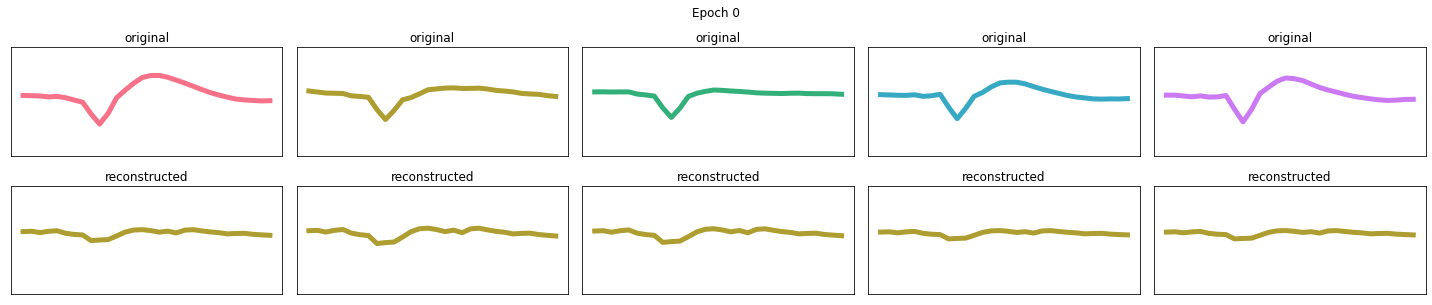

Epoch 2/200
49/49 [==============================] - 0s 6ms/step - loss: 3.2293 - reconstruction_loss: 147.4692 - classifier_loss: 1.6951 - reconstruction_accuracy: 0.1461 - classifier_accuracy: 0.2796 - val_loss: 2.6777 - val_reconstruction_loss: 104.4583 - val_classifier_loss: 1.5838 - val_reconstruction_accuracy: 0.1639 - val_classifier_accuracy: 0.2775
Epoch 3/200
49/49 [==============================] - 0s 5ms/step - loss: 2.7286 - reconstruction_loss: 120.6736 - classifier_loss: 1.4662 - reconstruction_accuracy: 0.1466 - classifier_accuracy: 0.3189 - val_loss: 2.4874 - val_reconstruction_loss: 101.5829 - val_classifier_loss: 1.4256 - val_reconstruction_accuracy: 0.1738 - val_classifier_accuracy: 0.2948
Epoch 4/200
49/49 [==============================] - 0s 6ms/step - loss: 2.5300 - reconstruction_loss: 112.1027 - classifier_loss: 1.3471 - reconstruction_accuracy: 0.1472 - classifier_accuracy: 0.3646 - val_loss: 2.3235 - val_reconstruction_loss: 94.9216 - val_classifier_loss: 1.3

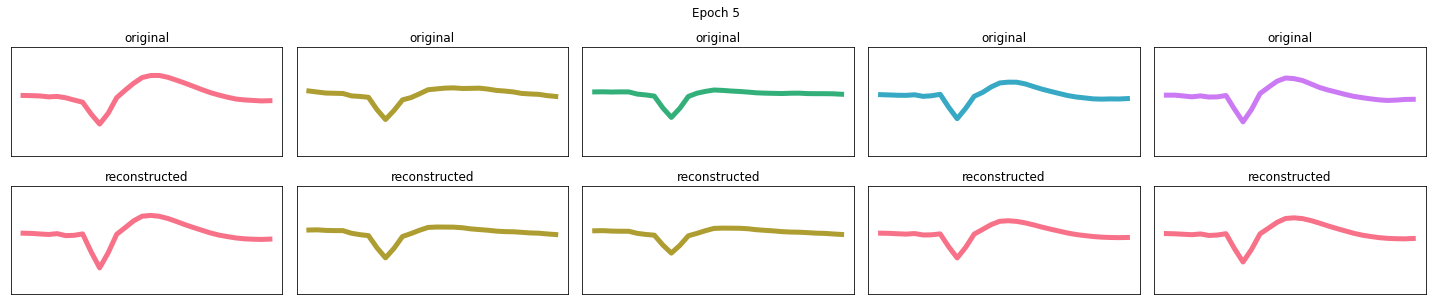

Epoch 7/200
49/49 [==============================] - 0s 5ms/step - loss: 2.2467 - reconstruction_loss: 102.7979 - classifier_loss: 1.1696 - reconstruction_accuracy: 0.1563 - classifier_accuracy: 0.4362 - val_loss: 2.1101 - val_reconstruction_loss: 91.3718 - val_classifier_loss: 1.1654 - val_reconstruction_accuracy: 0.1775 - val_classifier_accuracy: 0.3918
Epoch 8/200
49/49 [==============================] - 0s 6ms/step - loss: 2.2043 - reconstruction_loss: 102.3746 - classifier_loss: 1.1330 - reconstruction_accuracy: 0.1616 - classifier_accuracy: 0.4591 - val_loss: 2.0831 - val_reconstruction_loss: 91.3687 - val_classifier_loss: 1.1386 - val_reconstruction_accuracy: 0.1771 - val_classifier_accuracy: 0.3993
Epoch 9/200
49/49 [==============================] - 0s 6ms/step - loss: 2.1667 - reconstruction_loss: 101.8682 - classifier_loss: 1.1019 - reconstruction_accuracy: 0.1583 - classifier_accuracy: 0.4751 - val_loss: 2.0540 - val_reconstruction_loss: 91.0103 - val_classifier_loss: 1.113

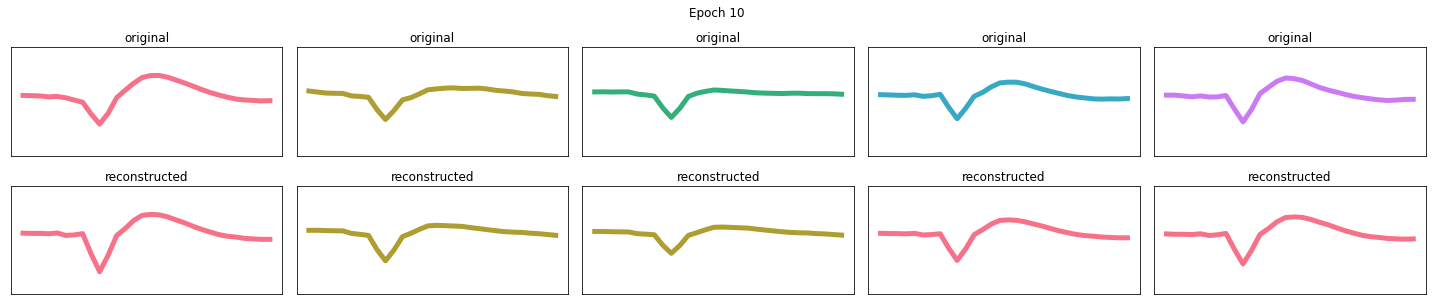

Epoch 12/200
49/49 [==============================] - 0s 5ms/step - loss: 2.0258 - reconstruction_loss: 102.5307 - classifier_loss: 0.9550 - reconstruction_accuracy: 0.1657 - classifier_accuracy: 0.5851 - val_loss: 1.8830 - val_reconstruction_loss: 91.9098 - val_classifier_loss: 0.9352 - val_reconstruction_accuracy: 0.1858 - val_classifier_accuracy: 0.5797
Epoch 13/200
49/49 [==============================] - 0s 6ms/step - loss: 1.9485 - reconstruction_loss: 102.8712 - classifier_loss: 0.8681 - reconstruction_accuracy: 0.1672 - classifier_accuracy: 0.6451 - val_loss: 1.7806 - val_reconstruction_loss: 92.5312 - val_classifier_loss: 0.8229 - val_reconstruction_accuracy: 0.1949 - val_classifier_accuracy: 0.6478
Epoch 14/200
49/49 [==============================] - 0s 6ms/step - loss: 1.8434 - reconstruction_loss: 103.4036 - classifier_loss: 0.7513 - reconstruction_accuracy: 0.1649 - classifier_accuracy: 0.7028 - val_loss: 1.6396 - val_reconstruction_loss: 93.6003 - val_classifier_loss: 0.

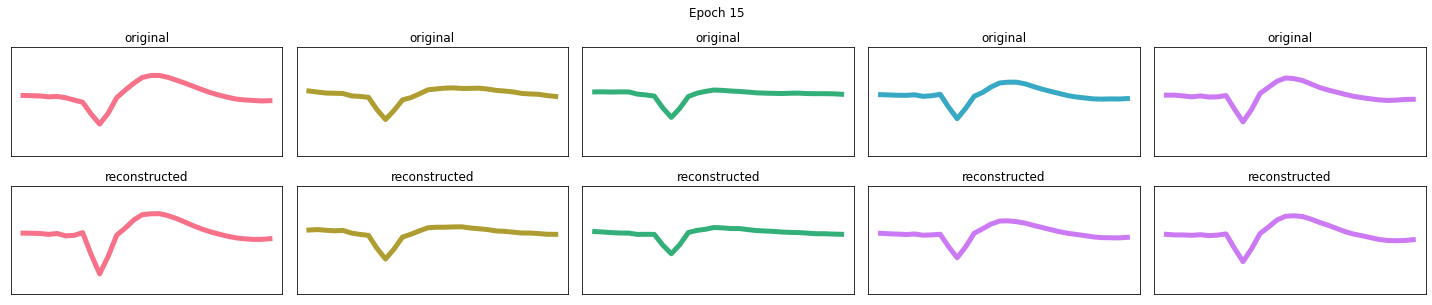

Epoch 17/200
49/49 [==============================] - 0s 6ms/step - loss: 1.5927 - reconstruction_loss: 104.3082 - classifier_loss: 0.4684 - reconstruction_accuracy: 0.1615 - classifier_accuracy: 0.8201 - val_loss: 1.3682 - val_reconstruction_loss: 94.9426 - val_classifier_loss: 0.3628 - val_reconstruction_accuracy: 0.1870 - val_classifier_accuracy: 0.8980
Epoch 18/200
49/49 [==============================] - 0s 5ms/step - loss: 1.5448 - reconstruction_loss: 104.1881 - classifier_loss: 0.4176 - reconstruction_accuracy: 0.1658 - classifier_accuracy: 0.8455 - val_loss: 1.3304 - val_reconstruction_loss: 94.4136 - val_classifier_loss: 0.3288 - val_reconstruction_accuracy: 0.1895 - val_classifier_accuracy: 0.9149
Epoch 19/200
49/49 [==============================] - 0s 5ms/step - loss: 1.4891 - reconstruction_loss: 103.8369 - classifier_loss: 0.3624 - reconstruction_accuracy: 0.1630 - classifier_accuracy: 0.8690 - val_loss: 1.2848 - val_reconstruction_loss: 95.2275 - val_classifier_loss: 0.

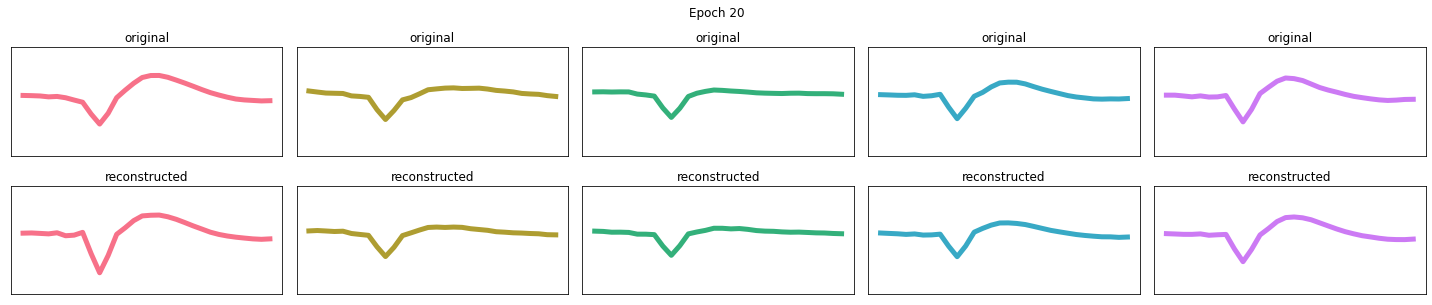

Epoch 22/200
49/49 [==============================] - 0s 6ms/step - loss: 1.3918 - reconstruction_loss: 102.9122 - classifier_loss: 0.2723 - reconstruction_accuracy: 0.1617 - classifier_accuracy: 0.9089 - val_loss: 1.1974 - val_reconstruction_loss: 94.9797 - val_classifier_loss: 0.1804 - val_reconstruction_accuracy: 0.1841 - val_classifier_accuracy: 0.9666
Epoch 23/200
49/49 [==============================] - 0s 5ms/step - loss: 1.3745 - reconstruction_loss: 102.5642 - classifier_loss: 0.2598 - reconstruction_accuracy: 0.1650 - classifier_accuracy: 0.9104 - val_loss: 1.1931 - val_reconstruction_loss: 94.8647 - val_classifier_loss: 0.1824 - val_reconstruction_accuracy: 0.1813 - val_classifier_accuracy: 0.9616
Epoch 24/200
49/49 [==============================] - 0s 5ms/step - loss: 1.3583 - reconstruction_loss: 102.4125 - classifier_loss: 0.2470 - reconstruction_accuracy: 0.1665 - classifier_accuracy: 0.9162 - val_loss: 1.1777 - val_reconstruction_loss: 94.8857 - val_classifier_loss: 0.

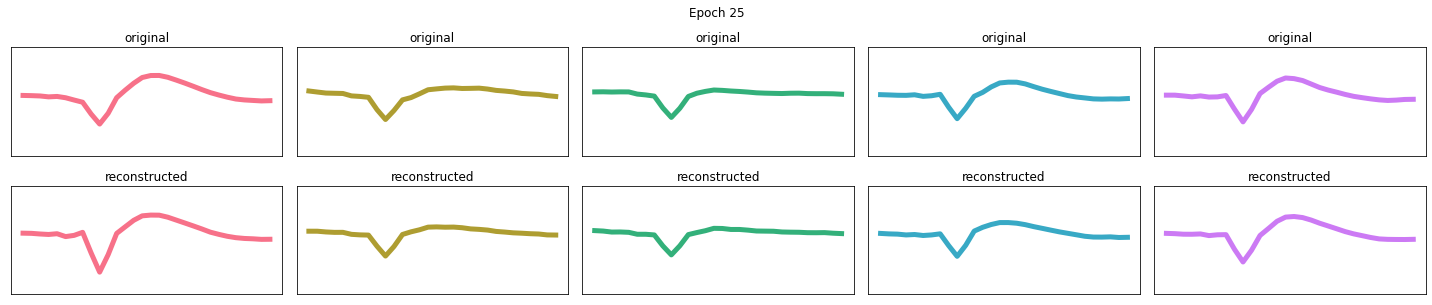

Epoch 27/200
49/49 [==============================] - 0s 5ms/step - loss: 1.3159 - reconstruction_loss: 101.6001 - classifier_loss: 0.2173 - reconstruction_accuracy: 0.1694 - classifier_accuracy: 0.9257 - val_loss: 1.1486 - val_reconstruction_loss: 94.7471 - val_classifier_loss: 0.1402 - val_reconstruction_accuracy: 0.1813 - val_classifier_accuracy: 0.9678
Epoch 28/200
49/49 [==============================] - 0s 5ms/step - loss: 1.3047 - reconstruction_loss: 101.4302 - classifier_loss: 0.2088 - reconstruction_accuracy: 0.1700 - classifier_accuracy: 0.9293 - val_loss: 1.1397 - val_reconstruction_loss: 94.1624 - val_classifier_loss: 0.1380 - val_reconstruction_accuracy: 0.1850 - val_classifier_accuracy: 0.9744
Epoch 29/200
49/49 [==============================] - 0s 5ms/step - loss: 1.2879 - reconstruction_loss: 101.0331 - classifier_loss: 0.1980 - reconstruction_accuracy: 0.1713 - classifier_accuracy: 0.9358 - val_loss: 1.1412 - val_reconstruction_loss: 94.2434 - val_classifier_loss: 0.

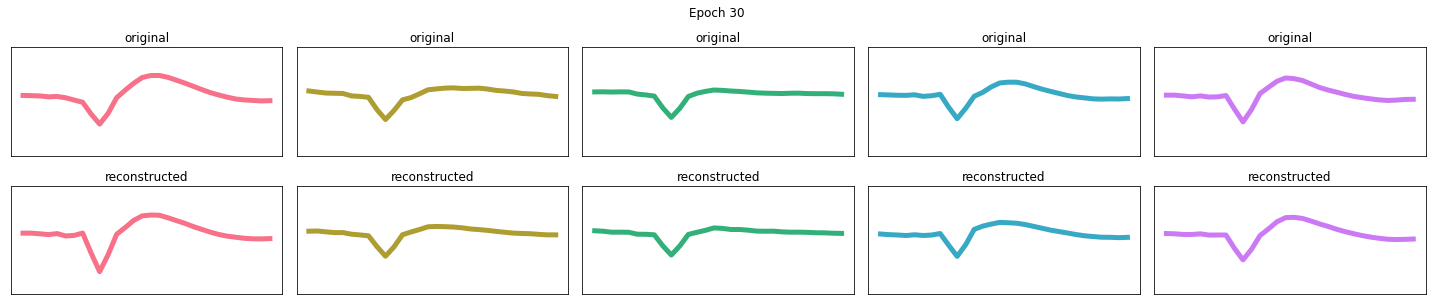

Epoch 32/200
49/49 [==============================] - 0s 6ms/step - loss: 1.2685 - reconstruction_loss: 100.5047 - classifier_loss: 0.1878 - reconstruction_accuracy: 0.1735 - classifier_accuracy: 0.9352 - val_loss: 1.1216 - val_reconstruction_loss: 94.1121 - val_classifier_loss: 0.1242 - val_reconstruction_accuracy: 0.1912 - val_classifier_accuracy: 0.9756
Epoch 33/200
49/49 [==============================] - 0s 5ms/step - loss: 1.2598 - reconstruction_loss: 100.1213 - classifier_loss: 0.1845 - reconstruction_accuracy: 0.1772 - classifier_accuracy: 0.9392 - val_loss: 1.1034 - val_reconstruction_loss: 93.8775 - val_classifier_loss: 0.1071 - val_reconstruction_accuracy: 0.1928 - val_classifier_accuracy: 0.9860
Epoch 34/200
49/49 [==============================] - 0s 5ms/step - loss: 1.2540 - reconstruction_loss: 99.9864 - classifier_loss: 0.1797 - reconstruction_accuracy: 0.1740 - classifier_accuracy: 0.9402 - val_loss: 1.1060 - val_reconstruction_loss: 93.6932 - val_classifier_loss: 0.1

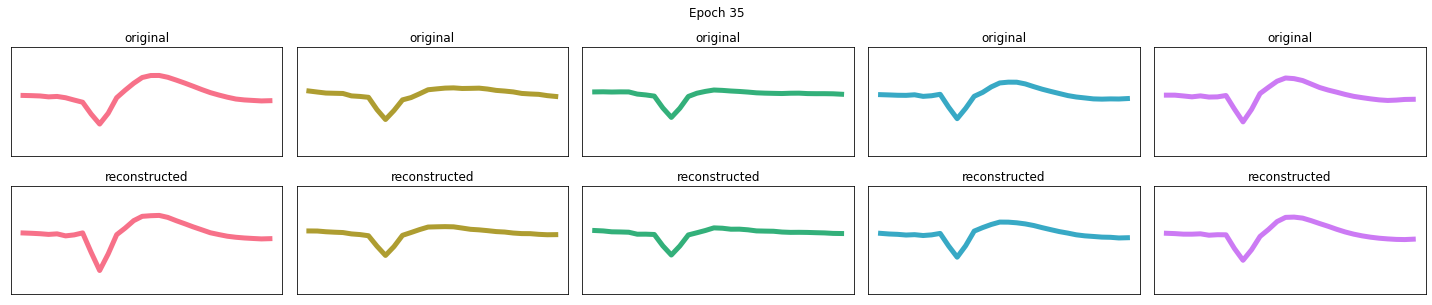

Epoch 37/200
49/49 [==============================] - 0s 5ms/step - loss: 1.2306 - reconstruction_loss: 99.0396 - classifier_loss: 0.1689 - reconstruction_accuracy: 0.1842 - classifier_accuracy: 0.9445 - val_loss: 1.0868 - val_reconstruction_loss: 93.2892 - val_classifier_loss: 0.0994 - val_reconstruction_accuracy: 0.1932 - val_classifier_accuracy: 0.9835
Epoch 38/200
49/49 [==============================] - 0s 5ms/step - loss: 1.2217 - reconstruction_loss: 98.5962 - classifier_loss: 0.1654 - reconstruction_accuracy: 0.1822 - classifier_accuracy: 0.9450 - val_loss: 1.0764 - val_reconstruction_loss: 92.1561 - val_classifier_loss: 0.1026 - val_reconstruction_accuracy: 0.1912 - val_classifier_accuracy: 0.9839
Epoch 39/200
49/49 [==============================] - 0s 6ms/step - loss: 1.2180 - reconstruction_loss: 98.3763 - classifier_loss: 0.1660 - reconstruction_accuracy: 0.1811 - classifier_accuracy: 0.9449 - val_loss: 1.0754 - val_reconstruction_loss: 92.0565 - val_classifier_loss: 0.102

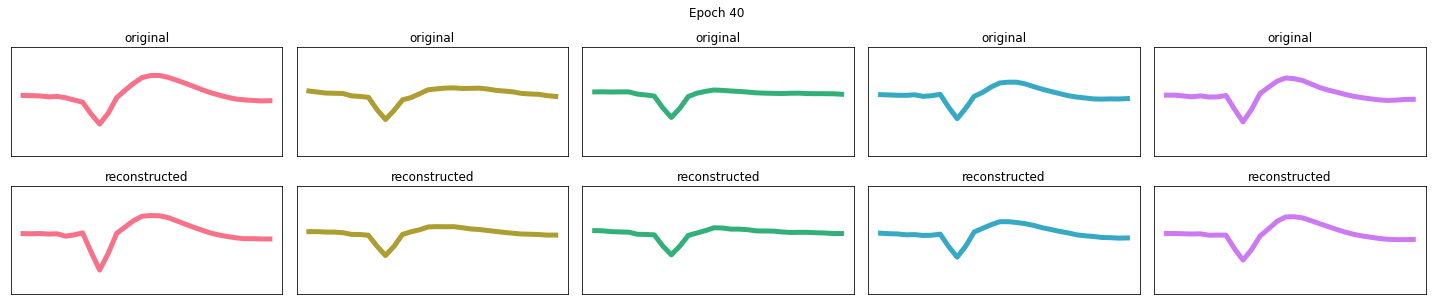

Epoch 42/200
49/49 [==============================] - 0s 6ms/step - loss: 1.1982 - reconstruction_loss: 97.4307 - classifier_loss: 0.1577 - reconstruction_accuracy: 0.1909 - classifier_accuracy: 0.9473 - val_loss: 1.0722 - val_reconstruction_loss: 91.8900 - val_classifier_loss: 0.1031 - val_reconstruction_accuracy: 0.1895 - val_classifier_accuracy: 0.9777
Epoch 43/200
49/49 [==============================] - 0s 6ms/step - loss: 1.1922 - reconstruction_loss: 97.1897 - classifier_loss: 0.1555 - reconstruction_accuracy: 0.1818 - classifier_accuracy: 0.9496 - val_loss: 1.0627 - val_reconstruction_loss: 91.1900 - val_classifier_loss: 0.1015 - val_reconstruction_accuracy: 0.2007 - val_classifier_accuracy: 0.9827
Epoch 44/200
49/49 [==============================] - 0s 6ms/step - loss: 1.1876 - reconstruction_loss: 97.0144 - classifier_loss: 0.1534 - reconstruction_accuracy: 0.1920 - classifier_accuracy: 0.9496 - val_loss: 1.0632 - val_reconstruction_loss: 91.2929 - val_classifier_loss: 0.099

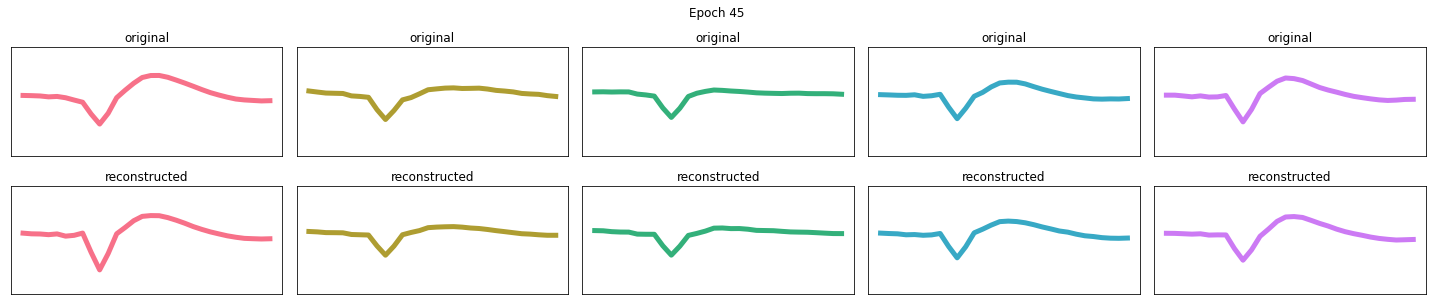

Epoch 47/200
49/49 [==============================] - 0s 5ms/step - loss: 1.1738 - reconstruction_loss: 96.4222 - classifier_loss: 0.1472 - reconstruction_accuracy: 0.1940 - classifier_accuracy: 0.9520 - val_loss: 1.0496 - val_reconstruction_loss: 90.7027 - val_classifier_loss: 0.0950 - val_reconstruction_accuracy: 0.1796 - val_classifier_accuracy: 0.9822
Epoch 48/200
49/49 [==============================] - 0s 5ms/step - loss: 1.1708 - reconstruction_loss: 96.2404 - classifier_loss: 0.1467 - reconstruction_accuracy: 0.1897 - classifier_accuracy: 0.9504 - val_loss: 1.0526 - val_reconstruction_loss: 90.3192 - val_classifier_loss: 0.1034 - val_reconstruction_accuracy: 0.1941 - val_classifier_accuracy: 0.9802
Epoch 49/200
49/49 [==============================] - 0s 6ms/step - loss: 1.1662 - reconstruction_loss: 96.1408 - classifier_loss: 0.1455 - reconstruction_accuracy: 0.1873 - classifier_accuracy: 0.9529 - val_loss: 1.0369 - val_reconstruction_loss: 90.2154 - val_classifier_loss: 0.088

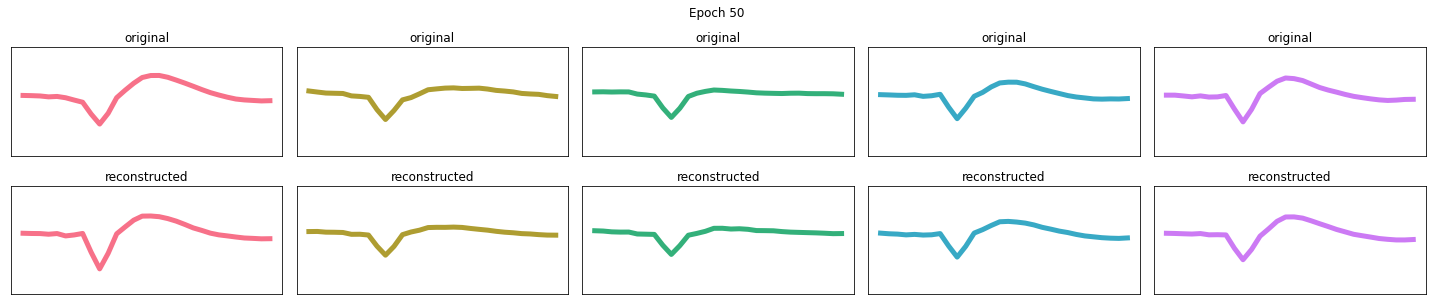

Epoch 52/200
49/49 [==============================] - 0s 6ms/step - loss: 1.1567 - reconstruction_loss: 95.7211 - classifier_loss: 0.1406 - reconstruction_accuracy: 0.1865 - classifier_accuracy: 0.9545 - val_loss: 1.0393 - val_reconstruction_loss: 90.5746 - val_classifier_loss: 0.0894 - val_reconstruction_accuracy: 0.1953 - val_classifier_accuracy: 0.9851
Epoch 53/200
49/49 [==============================] - 0s 6ms/step - loss: 1.1533 - reconstruction_loss: 95.6523 - classifier_loss: 0.1393 - reconstruction_accuracy: 0.1904 - classifier_accuracy: 0.9552 - val_loss: 1.0351 - val_reconstruction_loss: 90.6870 - val_classifier_loss: 0.0835 - val_reconstruction_accuracy: 0.1936 - val_classifier_accuracy: 0.9818
Epoch 54/200
49/49 [==============================] - 0s 6ms/step - loss: 1.1443 - reconstruction_loss: 95.2784 - classifier_loss: 0.1348 - reconstruction_accuracy: 0.1911 - classifier_accuracy: 0.9561 - val_loss: 1.0273 - val_reconstruction_loss: 89.7390 - val_classifier_loss: 0.085

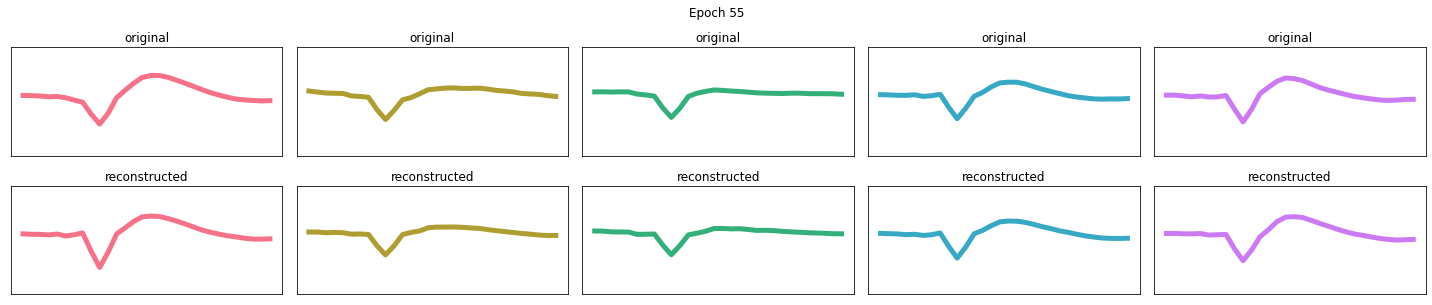

Epoch 57/200
49/49 [==============================] - 0s 5ms/step - loss: 1.1386 - reconstruction_loss: 95.0293 - classifier_loss: 0.1334 - reconstruction_accuracy: 0.1885 - classifier_accuracy: 0.9548 - val_loss: 1.0162 - val_reconstruction_loss: 89.2546 - val_classifier_loss: 0.0806 - val_reconstruction_accuracy: 0.1957 - val_classifier_accuracy: 0.9843
Epoch 58/200
49/49 [==============================] - 0s 6ms/step - loss: 1.1343 - reconstruction_loss: 94.7940 - classifier_loss: 0.1321 - reconstruction_accuracy: 0.1909 - classifier_accuracy: 0.9585 - val_loss: 1.0288 - val_reconstruction_loss: 90.8496 - val_classifier_loss: 0.0780 - val_reconstruction_accuracy: 0.1821 - val_classifier_accuracy: 0.9847
Epoch 59/200
49/49 [==============================] - 0s 6ms/step - loss: 1.1349 - reconstruction_loss: 94.8640 - classifier_loss: 0.1328 - reconstruction_accuracy: 0.1904 - classifier_accuracy: 0.9557 - val_loss: 1.0229 - val_reconstruction_loss: 89.5362 - val_classifier_loss: 0.085

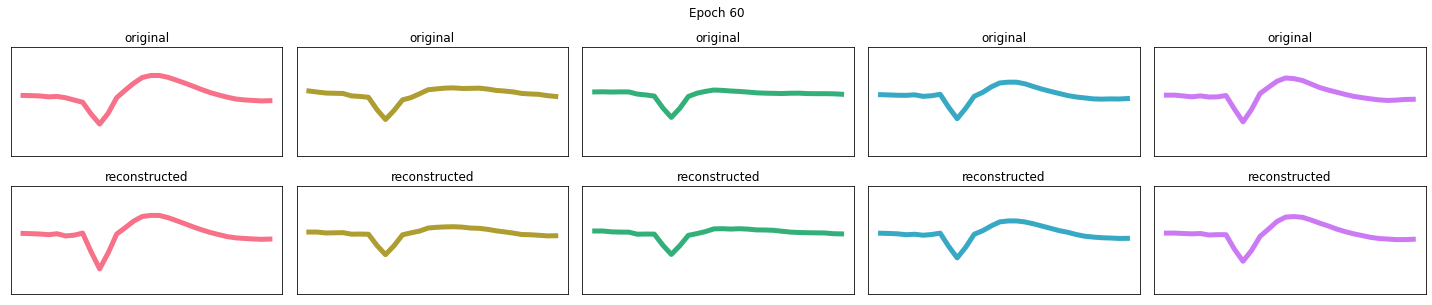

Epoch 62/200
49/49 [==============================] - 0s 5ms/step - loss: 1.1279 - reconstruction_loss: 94.6644 - classifier_loss: 0.1292 - reconstruction_accuracy: 0.1944 - classifier_accuracy: 0.9577 - val_loss: 1.0118 - val_reconstruction_loss: 89.9277 - val_classifier_loss: 0.0722 - val_reconstruction_accuracy: 0.1817 - val_classifier_accuracy: 0.9860
Epoch 63/200
49/49 [==============================] - 0s 6ms/step - loss: 1.1269 - reconstruction_loss: 94.5460 - classifier_loss: 0.1307 - reconstruction_accuracy: 0.1903 - classifier_accuracy: 0.9555 - val_loss: 1.0144 - val_reconstruction_loss: 89.9496 - val_classifier_loss: 0.0743 - val_reconstruction_accuracy: 0.1833 - val_classifier_accuracy: 0.9868
Epoch 64/200
49/49 [==============================] - 0s 5ms/step - loss: 1.1243 - reconstruction_loss: 94.5783 - classifier_loss: 0.1283 - reconstruction_accuracy: 0.1893 - classifier_accuracy: 0.9570 - val_loss: 1.0082 - val_reconstruction_loss: 89.4814 - val_classifier_loss: 0.074

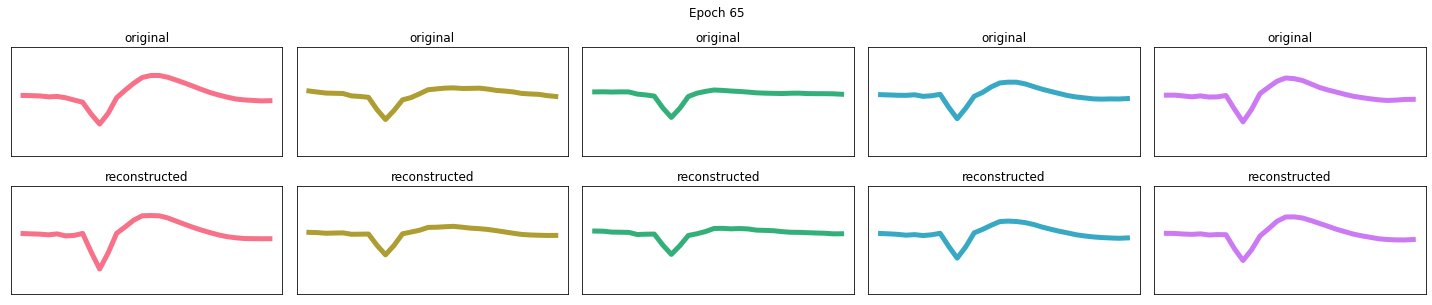

Epoch 67/200
49/49 [==============================] - 0s 6ms/step - loss: 1.1170 - reconstruction_loss: 94.1525 - classifier_loss: 0.1265 - reconstruction_accuracy: 0.2011 - classifier_accuracy: 0.9573 - val_loss: 0.9950 - val_reconstruction_loss: 88.6327 - val_classifier_loss: 0.0701 - val_reconstruction_accuracy: 0.2019 - val_classifier_accuracy: 0.9860
Epoch 68/200
49/49 [==============================] - 0s 6ms/step - loss: 1.1136 - reconstruction_loss: 94.1402 - classifier_loss: 0.1235 - reconstruction_accuracy: 0.1957 - classifier_accuracy: 0.9574 - val_loss: 1.0104 - val_reconstruction_loss: 90.1826 - val_classifier_loss: 0.0705 - val_reconstruction_accuracy: 0.1961 - val_classifier_accuracy: 0.9855
Epoch 69/200
49/49 [==============================] - 0s 5ms/step - loss: 1.1152 - reconstruction_loss: 94.2009 - classifier_loss: 0.1253 - reconstruction_accuracy: 0.1965 - classifier_accuracy: 0.9582 - val_loss: 1.0084 - val_reconstruction_loss: 89.3454 - val_classifier_loss: 0.077

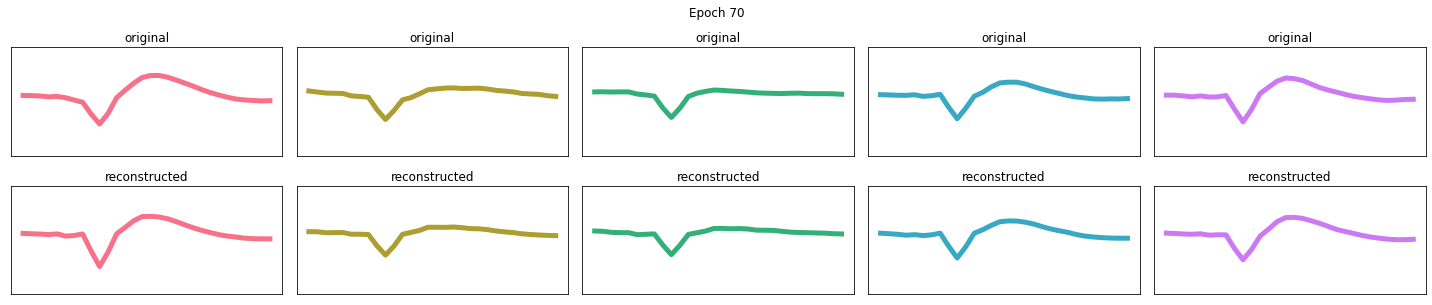

Epoch 72/200
49/49 [==============================] - 0s 6ms/step - loss: 1.1082 - reconstruction_loss: 93.9420 - classifier_loss: 0.1223 - reconstruction_accuracy: 0.1895 - classifier_accuracy: 0.9608 - val_loss: 0.9987 - val_reconstruction_loss: 89.1899 - val_classifier_loss: 0.0706 - val_reconstruction_accuracy: 0.1961 - val_classifier_accuracy: 0.9864
Epoch 73/200
49/49 [==============================] - 0s 6ms/step - loss: 1.1064 - reconstruction_loss: 93.8008 - classifier_loss: 0.1224 - reconstruction_accuracy: 0.1924 - classifier_accuracy: 0.9595 - val_loss: 0.9978 - val_reconstruction_loss: 89.2529 - val_classifier_loss: 0.0700 - val_reconstruction_accuracy: 0.1974 - val_classifier_accuracy: 0.9839
Epoch 74/200
49/49 [==============================] - 0s 5ms/step - loss: 1.1009 - reconstruction_loss: 93.5979 - classifier_loss: 0.1196 - reconstruction_accuracy: 0.1902 - classifier_accuracy: 0.9600 - val_loss: 0.9953 - val_reconstruction_loss: 88.9923 - val_classifier_loss: 0.069

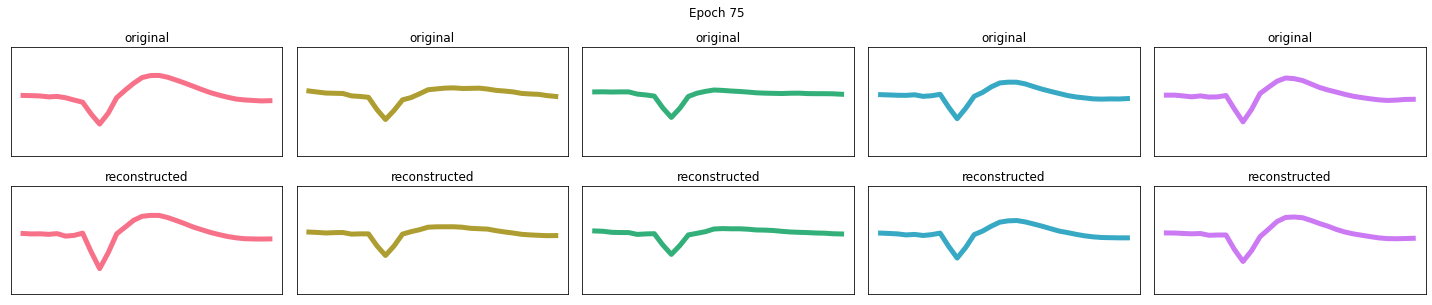

Epoch 77/200
49/49 [==============================] - 0s 6ms/step - loss: 1.1023 - reconstruction_loss: 93.7415 - classifier_loss: 0.1210 - reconstruction_accuracy: 0.1964 - classifier_accuracy: 0.9590 - val_loss: 1.0000 - val_reconstruction_loss: 89.3764 - val_classifier_loss: 0.0718 - val_reconstruction_accuracy: 0.2040 - val_classifier_accuracy: 0.9822
Epoch 78/200
49/49 [==============================] - 0s 5ms/step - loss: 1.0937 - reconstruction_loss: 93.4291 - classifier_loss: 0.1156 - reconstruction_accuracy: 0.1939 - classifier_accuracy: 0.9614 - val_loss: 0.9971 - val_reconstruction_loss: 89.2751 - val_classifier_loss: 0.0701 - val_reconstruction_accuracy: 0.1965 - val_classifier_accuracy: 0.9843
Epoch 79/200
49/49 [==============================] - 0s 6ms/step - loss: 1.0981 - reconstruction_loss: 93.4361 - classifier_loss: 0.1200 - reconstruction_accuracy: 0.1928 - classifier_accuracy: 0.9579 - val_loss: 0.9900 - val_reconstruction_loss: 89.0464 - val_classifier_loss: 0.065

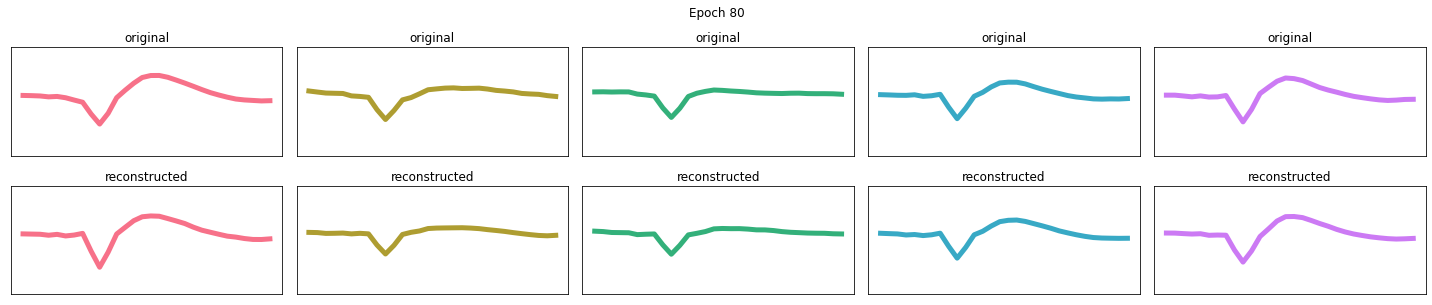

Epoch 82/200
49/49 [==============================] - 0s 5ms/step - loss: 1.0893 - reconstruction_loss: 93.1465 - classifier_loss: 0.1159 - reconstruction_accuracy: 0.1975 - classifier_accuracy: 0.9615 - val_loss: 0.9878 - val_reconstruction_loss: 88.9313 - val_classifier_loss: 0.0651 - val_reconstruction_accuracy: 0.1887 - val_classifier_accuracy: 0.9880
Epoch 83/200
49/49 [==============================] - 0s 6ms/step - loss: 1.0908 - reconstruction_loss: 93.2470 - classifier_loss: 0.1167 - reconstruction_accuracy: 0.1972 - classifier_accuracy: 0.9594 - val_loss: 0.9848 - val_reconstruction_loss: 88.9817 - val_classifier_loss: 0.0625 - val_reconstruction_accuracy: 0.1982 - val_classifier_accuracy: 0.9876
Epoch 84/200
49/49 [==============================] - 0s 6ms/step - loss: 1.0893 - reconstruction_loss: 93.1281 - classifier_loss: 0.1166 - reconstruction_accuracy: 0.1966 - classifier_accuracy: 0.9591 - val_loss: 0.9891 - val_reconstruction_loss: 89.5494 - val_classifier_loss: 0.060

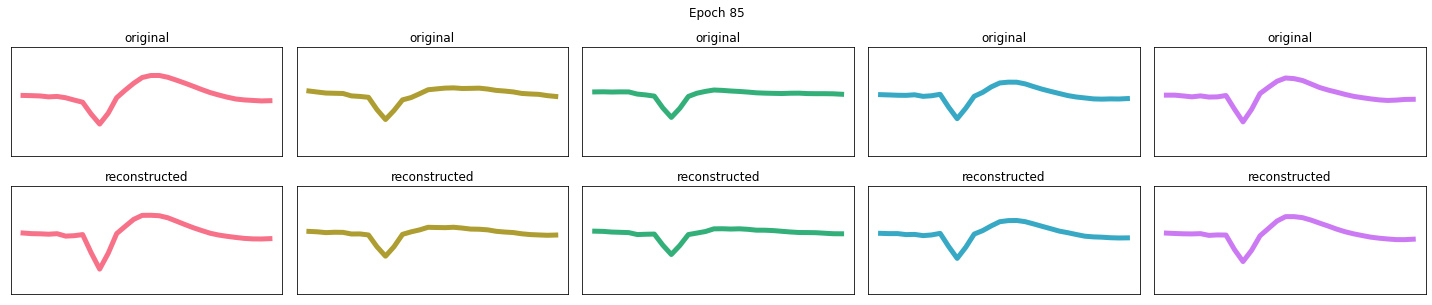

Epoch 87/200
49/49 [==============================] - 0s 6ms/step - loss: 1.0834 - reconstruction_loss: 92.9750 - classifier_loss: 0.1133 - reconstruction_accuracy: 0.1976 - classifier_accuracy: 0.9607 - val_loss: 0.9800 - val_reconstruction_loss: 88.4684 - val_classifier_loss: 0.0631 - val_reconstruction_accuracy: 0.2073 - val_classifier_accuracy: 0.9868
Epoch 88/200
49/49 [==============================] - 0s 5ms/step - loss: 1.0797 - reconstruction_loss: 92.9532 - classifier_loss: 0.1101 - reconstruction_accuracy: 0.1922 - classifier_accuracy: 0.9626 - val_loss: 0.9804 - val_reconstruction_loss: 88.9866 - val_classifier_loss: 0.0591 - val_reconstruction_accuracy: 0.2126 - val_classifier_accuracy: 0.9893
Epoch 89/200
49/49 [==============================] - 0s 6ms/step - loss: 1.0830 - reconstruction_loss: 93.1141 - classifier_loss: 0.1126 - reconstruction_accuracy: 0.1959 - classifier_accuracy: 0.9600 - val_loss: 0.9774 - val_reconstruction_loss: 88.8575 - val_classifier_loss: 0.058

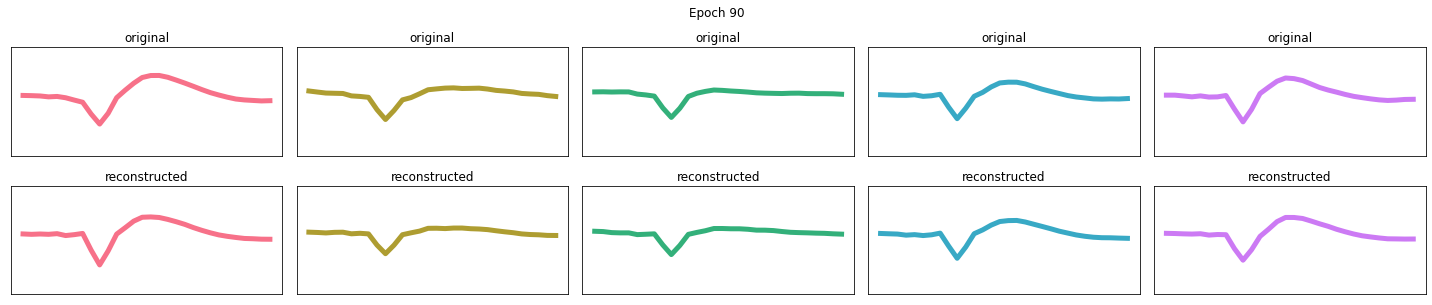

Epoch 92/200
49/49 [==============================] - 0s 7ms/step - loss: 1.0830 - reconstruction_loss: 93.0796 - classifier_loss: 0.1140 - reconstruction_accuracy: 0.1960 - classifier_accuracy: 0.9616 - val_loss: 0.9757 - val_reconstruction_loss: 88.5259 - val_classifier_loss: 0.0610 - val_reconstruction_accuracy: 0.1961 - val_classifier_accuracy: 0.9860
Epoch 93/200
49/49 [==============================] - 0s 6ms/step - loss: 1.0810 - reconstruction_loss: 92.8156 - classifier_loss: 0.1151 - reconstruction_accuracy: 0.2023 - classifier_accuracy: 0.9596 - val_loss: 0.9633 - val_reconstruction_loss: 87.5599 - val_classifier_loss: 0.0573 - val_reconstruction_accuracy: 0.2023 - val_classifier_accuracy: 0.9893
Epoch 94/200
49/49 [==============================] - 0s 6ms/step - loss: 1.0770 - reconstruction_loss: 92.8409 - classifier_loss: 0.1110 - reconstruction_accuracy: 0.1959 - classifier_accuracy: 0.9595 - val_loss: 0.9759 - val_reconstruction_loss: 88.7102 - val_classifier_loss: 0.058

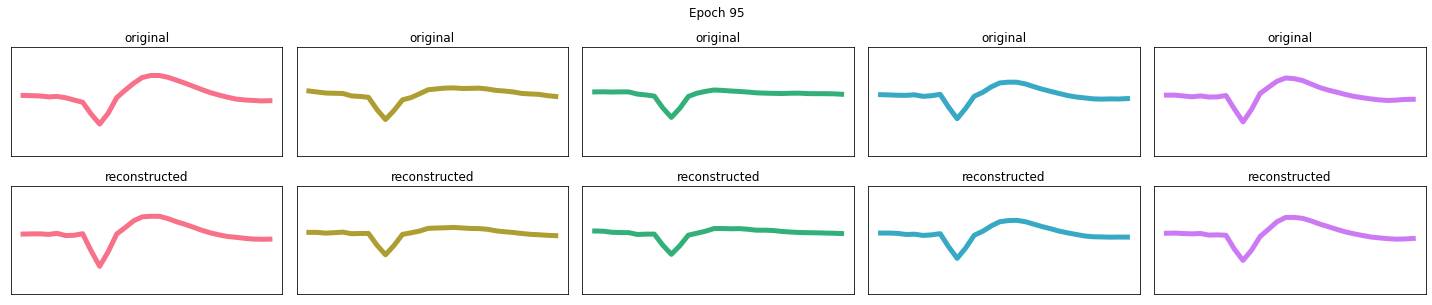

Epoch 97/200
49/49 [==============================] - 0s 7ms/step - loss: 1.0706 - reconstruction_loss: 92.6060 - classifier_loss: 0.1074 - reconstruction_accuracy: 0.1940 - classifier_accuracy: 0.9627 - val_loss: 0.9840 - val_reconstruction_loss: 89.2799 - val_classifier_loss: 0.0616 - val_reconstruction_accuracy: 0.2019 - val_classifier_accuracy: 0.9855
Epoch 98/200
49/49 [==============================] - 0s 7ms/step - loss: 1.0769 - reconstruction_loss: 92.7636 - classifier_loss: 0.1125 - reconstruction_accuracy: 0.1978 - classifier_accuracy: 0.9600 - val_loss: 0.9733 - val_reconstruction_loss: 88.6731 - val_classifier_loss: 0.0581 - val_reconstruction_accuracy: 0.2015 - val_classifier_accuracy: 0.9897
Epoch 99/200
49/49 [==============================] - 0s 6ms/step - loss: 1.0708 - reconstruction_loss: 92.6030 - classifier_loss: 0.1081 - reconstruction_accuracy: 0.1981 - classifier_accuracy: 0.9624 - val_loss: 0.9746 - val_reconstruction_loss: 88.9324 - val_classifier_loss: 0.057

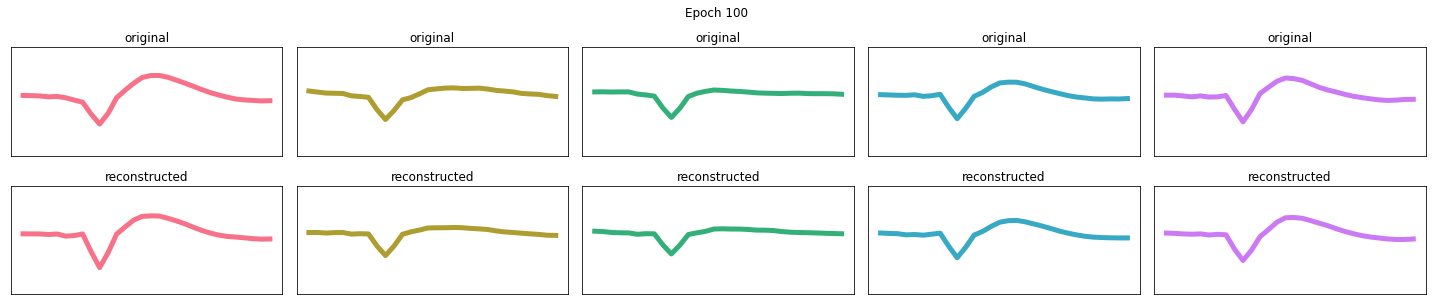

Epoch 102/200
49/49 [==============================] - 0s 6ms/step - loss: 1.0685 - reconstruction_loss: 92.4144 - classifier_loss: 0.1088 - reconstruction_accuracy: 0.1941 - classifier_accuracy: 0.9626 - val_loss: 0.9651 - val_reconstruction_loss: 88.2224 - val_classifier_loss: 0.0548 - val_reconstruction_accuracy: 0.2064 - val_classifier_accuracy: 0.9880
Epoch 103/200
49/49 [==============================] - 0s 6ms/step - loss: 1.0704 - reconstruction_loss: 92.5945 - classifier_loss: 0.1096 - reconstruction_accuracy: 0.1939 - classifier_accuracy: 0.9601 - val_loss: 0.9723 - val_reconstruction_loss: 88.7080 - val_classifier_loss: 0.0584 - val_reconstruction_accuracy: 0.1945 - val_classifier_accuracy: 0.9872
Epoch 104/200
49/49 [==============================] - 0s 7ms/step - loss: 1.0643 - reconstruction_loss: 92.3124 - classifier_loss: 0.1064 - reconstruction_accuracy: 0.1975 - classifier_accuracy: 0.9627 - val_loss: 0.9715 - val_reconstruction_loss: 88.6583 - val_classifier_loss: 0.

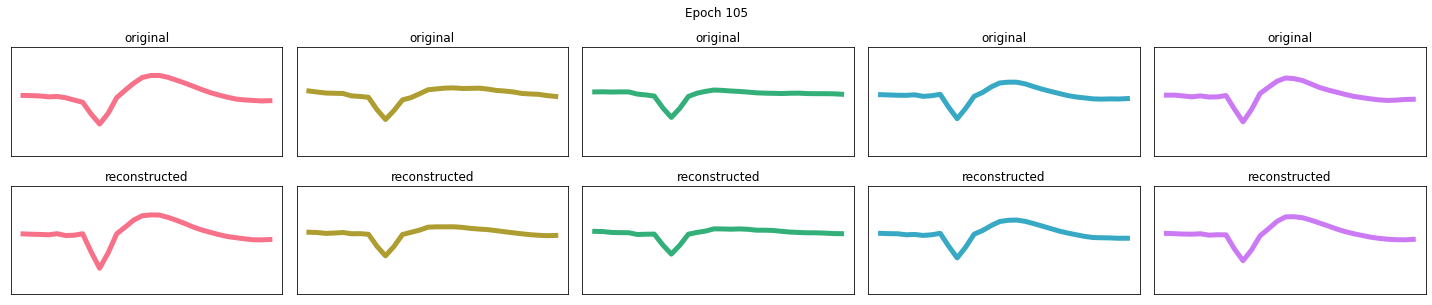

Epoch 107/200
49/49 [==============================] - 0s 6ms/step - loss: 1.0627 - reconstruction_loss: 92.3300 - classifier_loss: 0.1053 - reconstruction_accuracy: 0.1970 - classifier_accuracy: 0.9626 - val_loss: 0.9633 - val_reconstruction_loss: 88.3503 - val_classifier_loss: 0.0524 - val_reconstruction_accuracy: 0.1990 - val_classifier_accuracy: 0.9897
Epoch 108/200
49/49 [==============================] - 0s 6ms/step - loss: 1.0640 - reconstruction_loss: 92.1873 - classifier_loss: 0.1084 - reconstruction_accuracy: 0.2000 - classifier_accuracy: 0.9609 - val_loss: 0.9725 - val_reconstruction_loss: 88.6988 - val_classifier_loss: 0.0580 - val_reconstruction_accuracy: 0.2069 - val_classifier_accuracy: 0.9864
Epoch 109/200
49/49 [==============================] - 0s 6ms/step - loss: 1.0614 - reconstruction_loss: 92.4018 - classifier_loss: 0.1039 - reconstruction_accuracy: 0.2007 - classifier_accuracy: 0.9626 - val_loss: 0.9786 - val_reconstruction_loss: 89.1485 - val_classifier_loss: 0.

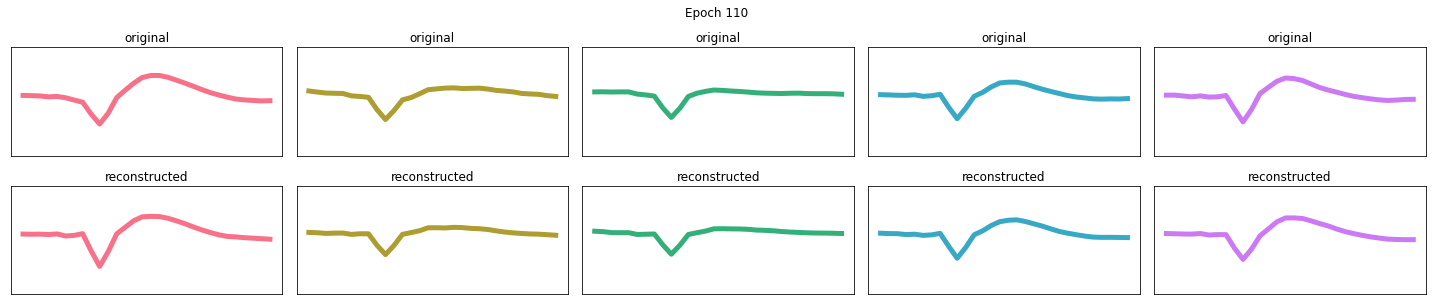

Epoch 112/200
49/49 [==============================] - 0s 6ms/step - loss: 1.0599 - reconstruction_loss: 92.1916 - classifier_loss: 0.1053 - reconstruction_accuracy: 0.1965 - classifier_accuracy: 0.9615 - val_loss: 0.9743 - val_reconstruction_loss: 88.6264 - val_classifier_loss: 0.0614 - val_reconstruction_accuracy: 0.2027 - val_classifier_accuracy: 0.9843
Epoch 113/200
49/49 [==============================] - 0s 6ms/step - loss: 1.0615 - reconstruction_loss: 92.1078 - classifier_loss: 0.1076 - reconstruction_accuracy: 0.2002 - classifier_accuracy: 0.9625 - val_loss: 0.9579 - val_reconstruction_loss: 87.3587 - val_classifier_loss: 0.0582 - val_reconstruction_accuracy: 0.1969 - val_classifier_accuracy: 0.9872
Epoch 114/200
49/49 [==============================] - 0s 7ms/step - loss: 1.0607 - reconstruction_loss: 92.3542 - classifier_loss: 0.1047 - reconstruction_accuracy: 0.1931 - classifier_accuracy: 0.9638 - val_loss: 0.9535 - val_reconstruction_loss: 87.7261 - val_classifier_loss: 0.

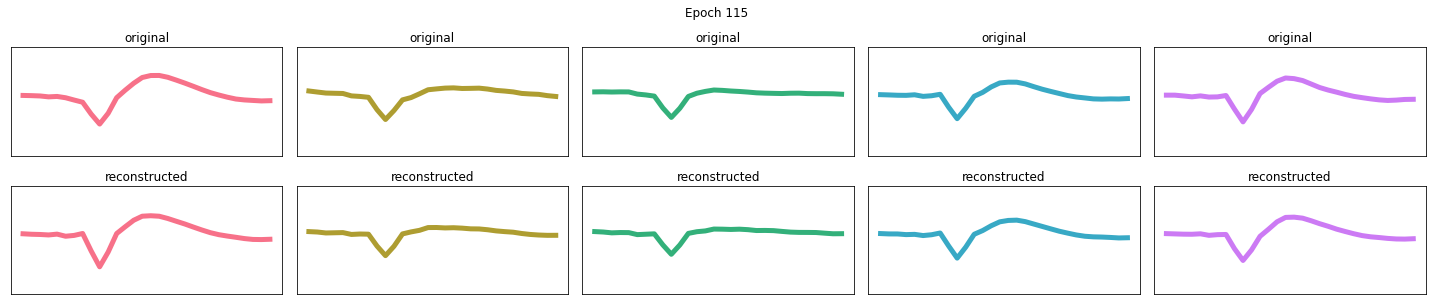

Epoch 117/200
49/49 [==============================] - 0s 6ms/step - loss: 1.0529 - reconstruction_loss: 91.7412 - classifier_loss: 0.1036 - reconstruction_accuracy: 0.1979 - classifier_accuracy: 0.9632 - val_loss: 0.9635 - val_reconstruction_loss: 88.1485 - val_classifier_loss: 0.0573 - val_reconstruction_accuracy: 0.1899 - val_classifier_accuracy: 0.9847
Epoch 118/200
49/49 [==============================] - 0s 7ms/step - loss: 1.0572 - reconstruction_loss: 92.1491 - classifier_loss: 0.1043 - reconstruction_accuracy: 0.1948 - classifier_accuracy: 0.9616 - val_loss: 0.9541 - val_reconstruction_loss: 87.8451 - val_classifier_loss: 0.0512 - val_reconstruction_accuracy: 0.2097 - val_classifier_accuracy: 0.9889
Epoch 119/200
49/49 [==============================] - 0s 6ms/step - loss: 1.0530 - reconstruction_loss: 91.9857 - classifier_loss: 0.1022 - reconstruction_accuracy: 0.1947 - classifier_accuracy: 0.9613 - val_loss: 0.9584 - val_reconstruction_loss: 87.6985 - val_classifier_loss: 0.

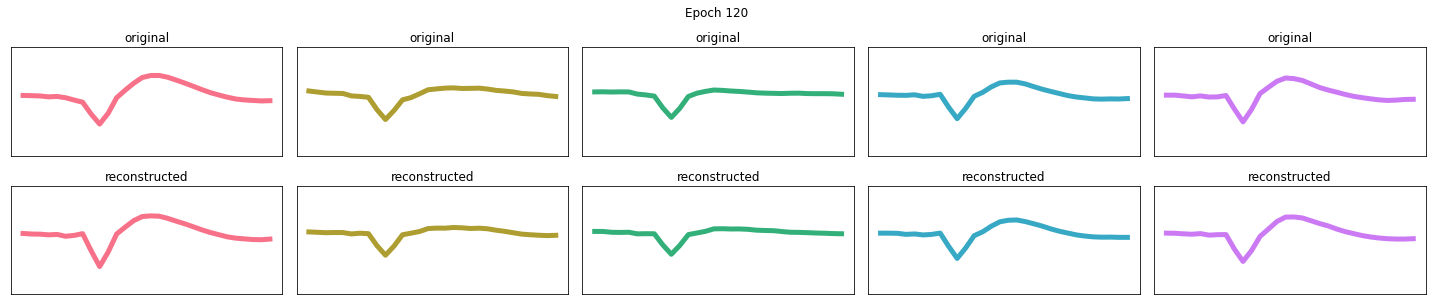

Epoch 122/200
49/49 [==============================] - 0s 7ms/step - loss: 1.0540 - reconstruction_loss: 92.1326 - classifier_loss: 0.1023 - reconstruction_accuracy: 0.2026 - classifier_accuracy: 0.9639 - val_loss: 0.9502 - val_reconstruction_loss: 87.5077 - val_classifier_loss: 0.0515 - val_reconstruction_accuracy: 0.1932 - val_classifier_accuracy: 0.9876
Epoch 123/200
49/49 [==============================] - 0s 7ms/step - loss: 1.0482 - reconstruction_loss: 91.7236 - classifier_loss: 0.1004 - reconstruction_accuracy: 0.1971 - classifier_accuracy: 0.9633 - val_loss: 0.9553 - val_reconstruction_loss: 88.1610 - val_classifier_loss: 0.0502 - val_reconstruction_accuracy: 0.2031 - val_classifier_accuracy: 0.9889
Epoch 124/200
49/49 [==============================] - 0s 6ms/step - loss: 1.0538 - reconstruction_loss: 91.9286 - classifier_loss: 0.1046 - reconstruction_accuracy: 0.1987 - classifier_accuracy: 0.9616 - val_loss: 0.9741 - val_reconstruction_loss: 88.6444 - val_classifier_loss: 0.

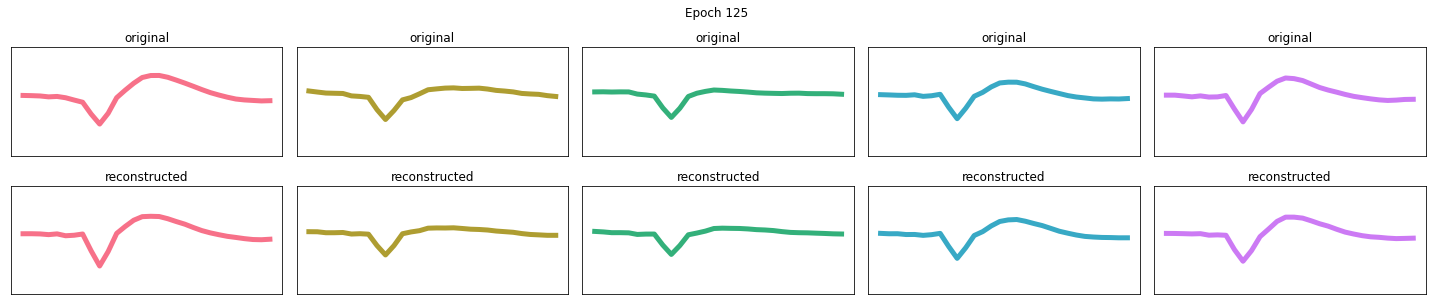

Epoch 127/200
49/49 [==============================] - 0s 6ms/step - loss: 1.0493 - reconstruction_loss: 91.8208 - classifier_loss: 0.1017 - reconstruction_accuracy: 0.2013 - classifier_accuracy: 0.9636 - val_loss: 0.9523 - val_reconstruction_loss: 88.2875 - val_classifier_loss: 0.0466 - val_reconstruction_accuracy: 0.1961 - val_classifier_accuracy: 0.9901
Epoch 128/200
49/49 [==============================] - 0s 7ms/step - loss: 1.0462 - reconstruction_loss: 91.7742 - classifier_loss: 0.0990 - reconstruction_accuracy: 0.1996 - classifier_accuracy: 0.9636 - val_loss: 0.9525 - val_reconstruction_loss: 88.1322 - val_classifier_loss: 0.0484 - val_reconstruction_accuracy: 0.1924 - val_classifier_accuracy: 0.9889
Epoch 129/200
49/49 [==============================] - 0s 7ms/step - loss: 1.0501 - reconstruction_loss: 91.8592 - classifier_loss: 0.1021 - reconstruction_accuracy: 0.1985 - classifier_accuracy: 0.9625 - val_loss: 0.9640 - val_reconstruction_loss: 89.1280 - val_classifier_loss: 0.

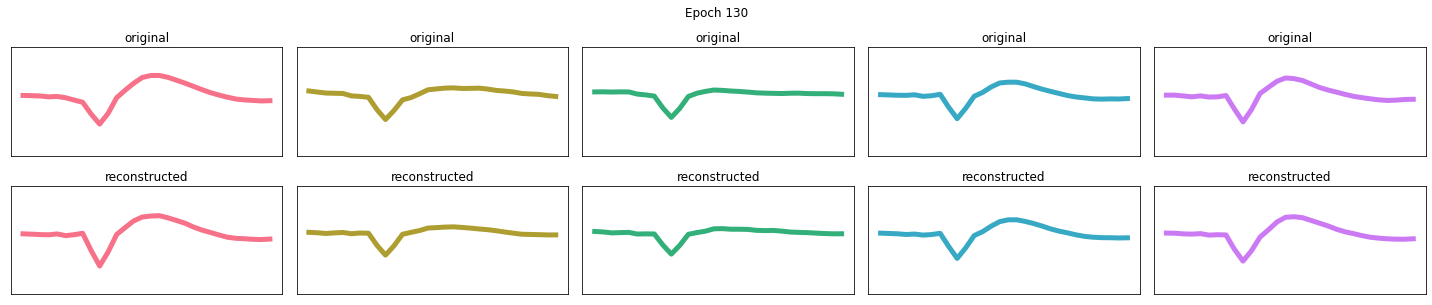

Epoch 132/200
49/49 [==============================] - 0s 7ms/step - loss: 1.0435 - reconstruction_loss: 91.4468 - classifier_loss: 0.1003 - reconstruction_accuracy: 0.2019 - classifier_accuracy: 0.9652 - val_loss: 0.9624 - val_reconstruction_loss: 88.6467 - val_classifier_loss: 0.0529 - val_reconstruction_accuracy: 0.1928 - val_classifier_accuracy: 0.9868
Epoch 133/200
49/49 [==============================] - 0s 6ms/step - loss: 1.0451 - reconstruction_loss: 91.6774 - classifier_loss: 0.0999 - reconstruction_accuracy: 0.1969 - classifier_accuracy: 0.9624 - val_loss: 0.9536 - val_reconstruction_loss: 88.2392 - val_classifier_loss: 0.0485 - val_reconstruction_accuracy: 0.2002 - val_classifier_accuracy: 0.9884
Epoch 134/200
49/49 [==============================] - 0s 6ms/step - loss: 1.0458 - reconstruction_loss: 91.7654 - classifier_loss: 0.1001 - reconstruction_accuracy: 0.2009 - classifier_accuracy: 0.9633 - val_loss: 0.9467 - val_reconstruction_loss: 87.3974 - val_classifier_loss: 0.

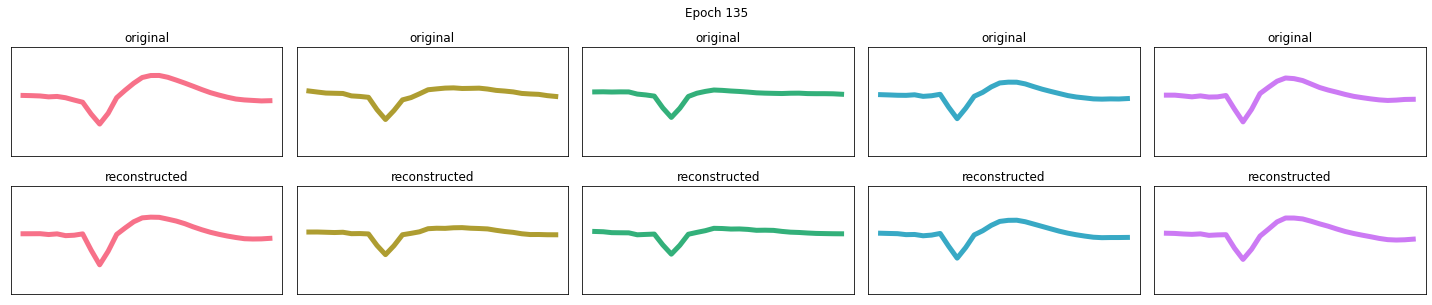

Epoch 137/200
49/49 [==============================] - 0s 7ms/step - loss: 1.0377 - reconstruction_loss: 91.4792 - classifier_loss: 0.0952 - reconstruction_accuracy: 0.2020 - classifier_accuracy: 0.9662 - val_loss: 0.9492 - val_reconstruction_loss: 88.1858 - val_classifier_loss: 0.0454 - val_reconstruction_accuracy: 0.1994 - val_classifier_accuracy: 0.9893
Epoch 138/200
49/49 [==============================] - 0s 6ms/step - loss: 1.0419 - reconstruction_loss: 91.6781 - classifier_loss: 0.0977 - reconstruction_accuracy: 0.2007 - classifier_accuracy: 0.9646 - val_loss: 0.9478 - val_reconstruction_loss: 87.6166 - val_classifier_loss: 0.0499 - val_reconstruction_accuracy: 0.2019 - val_classifier_accuracy: 0.9880
Epoch 139/200
49/49 [==============================] - 0s 6ms/step - loss: 1.0429 - reconstruction_loss: 91.6306 - classifier_loss: 0.0992 - reconstruction_accuracy: 0.1998 - classifier_accuracy: 0.9637 - val_loss: 0.9518 - val_reconstruction_loss: 88.4828 - val_classifier_loss: 0.

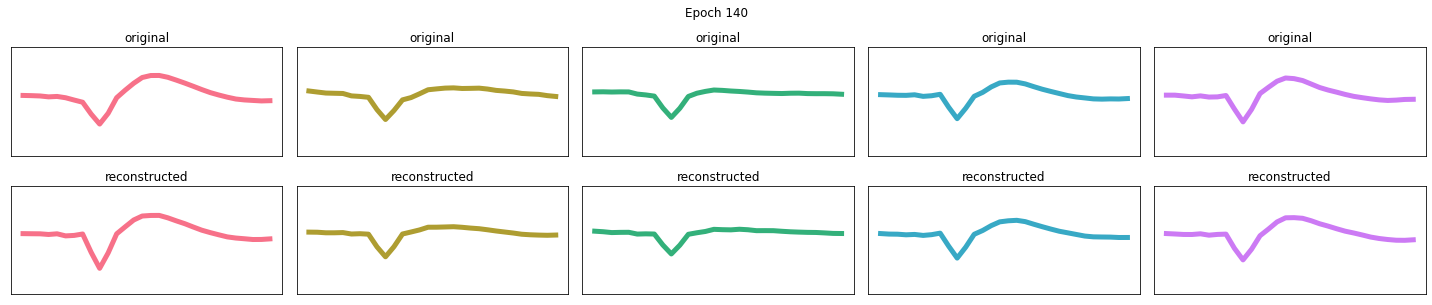

Epoch 142/200
49/49 [==============================] - 0s 7ms/step - loss: 1.0447 - reconstruction_loss: 91.7992 - classifier_loss: 0.1001 - reconstruction_accuracy: 0.1995 - classifier_accuracy: 0.9616 - val_loss: 0.9443 - val_reconstruction_loss: 87.8820 - val_classifier_loss: 0.0457 - val_reconstruction_accuracy: 0.1965 - val_classifier_accuracy: 0.9913
Epoch 143/200
49/49 [==============================] - 0s 6ms/step - loss: 1.0415 - reconstruction_loss: 91.5233 - classifier_loss: 0.0998 - reconstruction_accuracy: 0.1991 - classifier_accuracy: 0.9639 - val_loss: 0.9434 - val_reconstruction_loss: 87.7287 - val_classifier_loss: 0.0451 - val_reconstruction_accuracy: 0.2110 - val_classifier_accuracy: 0.9909
Epoch 144/200
49/49 [==============================] - 0s 7ms/step - loss: 1.0441 - reconstruction_loss: 91.5838 - classifier_loss: 0.1016 - reconstruction_accuracy: 0.1955 - classifier_accuracy: 0.9629 - val_loss: 0.9511 - val_reconstruction_loss: 87.7530 - val_classifier_loss: 0.

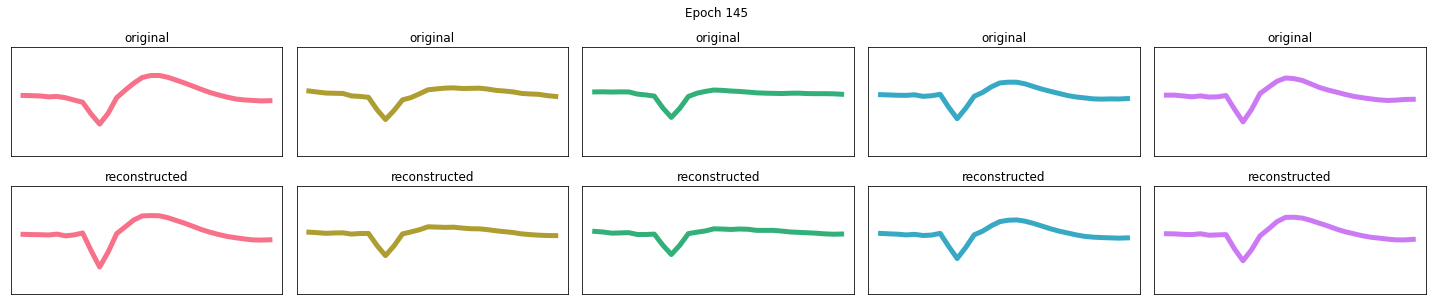

Epoch 147/200
49/49 [==============================] - 0s 6ms/step - loss: 1.0345 - reconstruction_loss: 91.4220 - classifier_loss: 0.0942 - reconstruction_accuracy: 0.2015 - classifier_accuracy: 0.9655 - val_loss: 0.9409 - val_reconstruction_loss: 87.4078 - val_classifier_loss: 0.0460 - val_reconstruction_accuracy: 0.1932 - val_classifier_accuracy: 0.9897
Epoch 148/200
49/49 [==============================] - 0s 6ms/step - loss: 1.0357 - reconstruction_loss: 91.4345 - classifier_loss: 0.0952 - reconstruction_accuracy: 0.2026 - classifier_accuracy: 0.9639 - val_loss: 0.9576 - val_reconstruction_loss: 87.8953 - val_classifier_loss: 0.0577 - val_reconstruction_accuracy: 0.2052 - val_classifier_accuracy: 0.9839
Epoch 149/200
49/49 [==============================] - 0s 6ms/step - loss: 1.0359 - reconstruction_loss: 91.2744 - classifier_loss: 0.0973 - reconstruction_accuracy: 0.2004 - classifier_accuracy: 0.9645 - val_loss: 0.9415 - val_reconstruction_loss: 87.5323 - val_classifier_loss: 0.

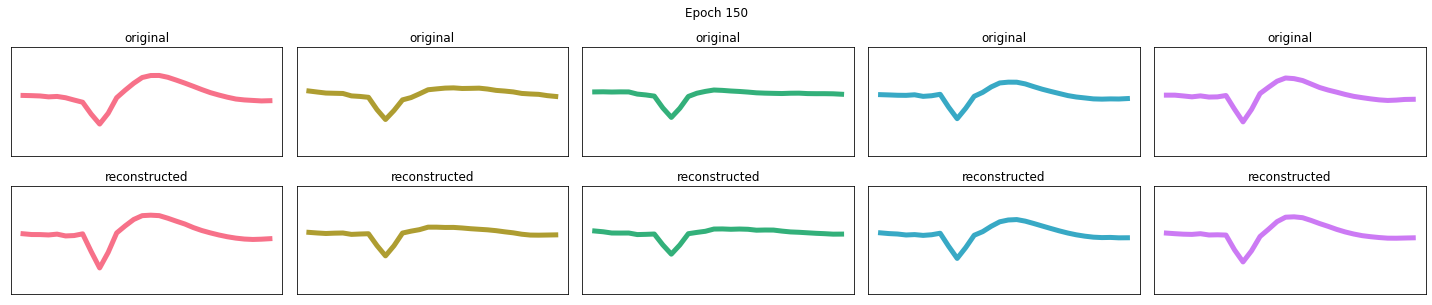

Epoch 00151: early stopping


In [ ]:
#autoencoder.load_weights('model_mouse2.h5') #reinitialize
history = autoencoder.fit([X_train, channels_train_enc], [X_train, y_train],
                epochs=200,
                batch_size=200,
                callbacks=[es, model_check, image_printing, outlier_eval],
                validation_data=([X_eval, channels_eval_enc], [X_eval, y_eval]))

In [ ]:
autoencoder.save_weights('best_model_current_mouse2.h5')

In [44]:
autoencoder.load_weights('./data/best_model_current_mouse2.h5')

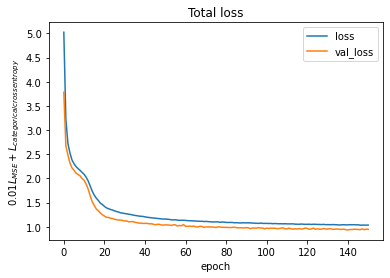

In [ ]:
plt.title('Total loss')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('epoch')
plt.ylabel('$0.01L_{MSE} + L_{categorical crossentropy}$')
plt.savefig('./results/AE_dense_classifier/total_loss_mouse2.pdf')
plt.legend()

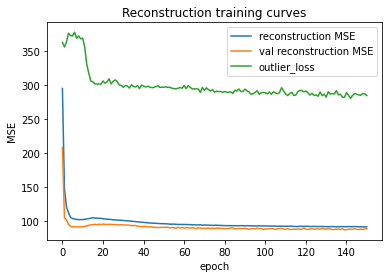

In [ ]:
#reconstruction loss
plt.title('Reconstruction training curves')
plt.xlabel('epoch')
plt.ylabel('MSE')
plt.plot(history.history['reconstruction_loss'], label='reconstruction MSE')
plt.plot(history.history['val_reconstruction_loss'], label='val reconstruction MSE')
plt.plot(history.history['reconstruction_outlier_loss'], label='outlier_loss')
plt.savefig('./results/AE_dense_classifier/rec_loss_mouse2.pdf')
plt.legend()

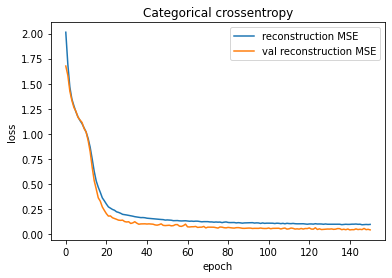

In [ ]:
#reconstruction loss
plt.title('Categorical crossentropy')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(history.history['classifier_loss'], label='reconstruction MSE')
plt.plot(history.history['val_classifier_loss'], label='val reconstruction MSE')

plt.savefig('./results/AE_dense_classifier/cat_crossentropy_mouse2.pdf')
plt.legend()

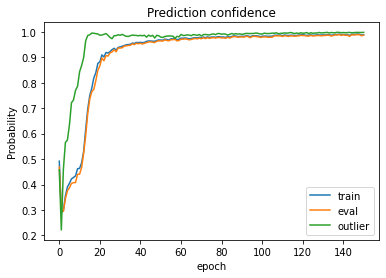

In [ ]:
#reconstruction loss
plt.title('Prediction confidence')
plt.xlabel('epoch')
plt.ylabel('Probability')
plt.plot(history.history['max_prob_train'], label='train')
plt.plot(history.history['max_prob_eval'], label='eval')
plt.plot(history.history['max_prob_outlier'], label='outlier')
plt.savefig('./results/AE_dense_classifier/max_prob_confidence_mouse2.pdf')
plt.legend()

## Testing

In [45]:
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train, channels_train_enc)

KNeighborsClassifier(n_neighbors=3)

In [46]:
channels_anomaly = neigh.predict(X_anomaly)

In [47]:
#getting relevant data
encoded_train = encoder([X_train, channels_train_enc])
encoded_test = encoder([X_test, channels_test_enc])
encoded_test_all_spikes = encoder([X_test_all_spikes, channels_test_all_spikes_enc])

In [48]:
encoded_anomaly = encoder([X_anomaly, channels_anomaly])

In [49]:
decoded_train, pred_labels_train = autoencoder([X_train, channels_train_enc])
decoded_test, pred_labels_test = autoencoder([X_test, channels_test_enc])
decoded_test_all, pred_labels_test_all = autoencoder([X_test_all_spikes, channels_test_all_spikes_enc])

In [50]:
decoded_anomaly, pred_labels_anomaly = autoencoder([X_anomaly, channels_anomaly])

In [51]:
y_pred_test = np.argmax(pred_labels_test, axis=1)
y_pred_test_all = np.argmax(pred_labels_test_all, axis=1)
y_pred_train = np.argmax(pred_labels_train, axis=1)

### Classification accuracy

In [52]:
#save to dataframe
df_labels = pd.DataFrame(labels_test_all_spikes, columns=['true_test'])
df_labels['pred_test'] = y_pred_test_all
df_labels['mouse'] = 2

In [53]:
#df_labels.to_csv('./autoencoder_notebooks/mouse2_test_labels.csv')

In [54]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

#### On test dataset noisy spikes


In [55]:
print(classification_report(labels_test_all_spikes, y_pred_test_all))

              precision    recall  f1-score   support

           0       0.83      0.69      0.76      6214
           1       0.77      0.88      0.82      7283
           2       0.95      0.70      0.81      6285
           3       0.69      0.70      0.70      5867
           4       0.88      1.00      0.93     10588

    accuracy                           0.82     36237
   macro avg       0.82      0.80      0.80     36237
weighted avg       0.83      0.82      0.82     36237



In [56]:
disp = ConfusionMatrixDisplay(confusion_matrix(labels_test_all_spikes, y_pred_test_all, normalize='true'),
                              display_labels=[i for i in range(len(np.unique(labels_train)))])

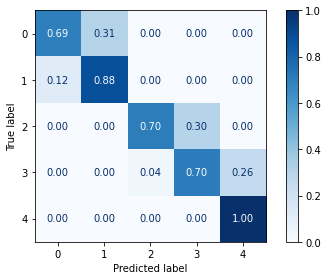

In [57]:
disp.plot(cmap=plt.cm.Blues, values_format='.2f')
disp.figure_.tight_layout()
disp.ax_.grid(False)

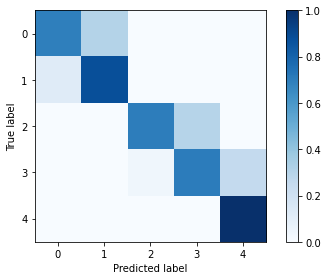

In [58]:
disp.plot(cmap=plt.cm.Blues, values_format='.2f', include_values=False)
disp.figure_.tight_layout()
disp.ax_.grid(False)

In [59]:
from sklearn.ensemble import RandomForestClassifier

### Reconstruction

#### On noisy test data

In [65]:
import seaborn as sns
color_list = sns.color_palette('tab10', nb_neurons)

In [60]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

def plot_average_waveform_reconstructions(model,
                                  X_test,
                                  labels_test,
                                  test_channels,
                                  color_list,
                                  savefig,
                                  savefig_path,
                                  anomaly=False):
  fig, axs = plt.subplots(2, len(np.unique(labels_test)), figsize=(20, 4))
  scale = (np.min(X_test), np.max(X_test))
  for i, neuron_label in enumerate(np.unique(labels_test)):
      mask = labels_test == neuron_label
      mean_waveform = np.mean(X_test[mask], axis=0)
      current_channel = test_channels[mask][0]
      if anomaly:
        color = 'blue'
      else:
        color = color_list[neuron_label]
      axs[0, i].plot(mean_waveform,
                     c=color, lw=5.)
      
      axs[0, i].set_title('original')
      axs[0, i].set_xticks([])
      axs[0, i].set_yticks([])
      axs[0, i].set_ylim(scale)
      #reconstruction
      decoded_waveform, pred_label = model([np.reshape(mean_waveform, (1, -1)),
                                            np.reshape(current_channel, (1, -1))])
      pred_label = np.argmax(pred_label)
      if anomaly:
        color_pred = 'red'
      else:
        color_pred = color_list[pred_label] 
      axs[1, i].plot(decoded_waveform[0], c=color_pred, lw=5.)
      axs[1, i].set_title('reconstructed')
      axs[1, i].set_xticks([])
      axs[1, i].set_yticks([])
      axs[1, i].set_ylim(scale)
    
  if savefig:
    plt.savefig(savefig_path)
  fig.tight_layout()
  plt.show()

def plot_latent_space(encoded,
                      labels,
                      color_dic,
                      projection_method,
                      savefig,
                      savefig_path,
                      s=5.,
                      lw=1.,
                      borders=True,
                      sil_score_show=True,
                      edgecolor='black',
                      xlim=(-25, 25),
                      figsize=(10, 10),
                      ylim=(-20, 30),
                      title='UMAP embedding of AE latent space'):
  if projection_method == 'tsne':
    print('TSNE calculation under way')
    X_embedded = TSNE(n_components=2).fit_transform(encoded)
    plt.scatter(X_embedded[:, 0],
                X_embedded[:, 1],
                c=list(map(color_dic.get, labels)),
                s=2.)
    plt.xlabel('tSNE 1')
    plt.ylabel('tSNE 2')
    plt.title('tSNE embedding of AE latent space')
  elif projection_method == 'umap':
    print('UMAP calculation under way')
    X_embedded = umap.UMAP(n_neighbors=50,
                           min_dist=0.1,
                           metric='euclidean').fit_transform(encoded)
    
    plt.scatter(X_embedded[:, 0],
                X_embedded[:, 1],
                c=list(map(color_dic.get, labels)),
                s=2.)
    plt.xlabel('UMAP 1')
    plt.ylabel('UMAP 2')
    plt.title(title)                     
  elif projection_method == 'pca':
    print('PCA calculation under way')
    X_embedded = PCA(n_components=2).fit_transform(encoded)
    plt.scatter(X_embedded[:, 0],
                X_embedded[:, 1],
                s=2.,
                c=list(map(color_dic.get, labels)))
    plt.xlabel('PC 1')
    plt.ylabel('PC 2')
    plt.title('PCA embedding of AE latent space')
  elif projection_method == 'none':
    X_embedded = encoded
    fig, ax = plt.subplots(figsize=figsize)
    ax.scatter(X_embedded[:, 0],
                X_embedded[:, 1],
                s=s,
                lw=lw,
                edgecolor=edgecolor,
                c=list(map(color_dic.get, labels)))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    if sil_score_show:
      if len(np.unique(labels)) > 1:
        sil_score = silhouette_score(X_embedded, labels)
        print('sil score '+str(sil_score))
    if borders:
      ax.set_xlabel('z 1')
      ax.set_ylabel('z 2')
      ax.set_title('AE latent space')
    else:
      ax.spines['top'].set_visible(False)
      ax.spines['right'].set_visible(False)
      ax.spines['left'].set_visible(False)
      ax.spines['bottom'].set_visible(False)

  if savefig:
    if 'jpg' in savefig_path.split('.')[-1]:
      print('saving jpg')
      plt.savefig(savefig_path, dpi=300)
    else:
      plt.savefig(savefig_path)
  plt.show()
  if sil_score_show:
    if len(np.unique(labels)) > 1:
      return X_embedded, sil_score
    else:
      return X_embedded
  else:
    return X_embedded

In [61]:
y_test_all_spikes = tf.keras.utils.to_categorical(labels_test_all_spikes)

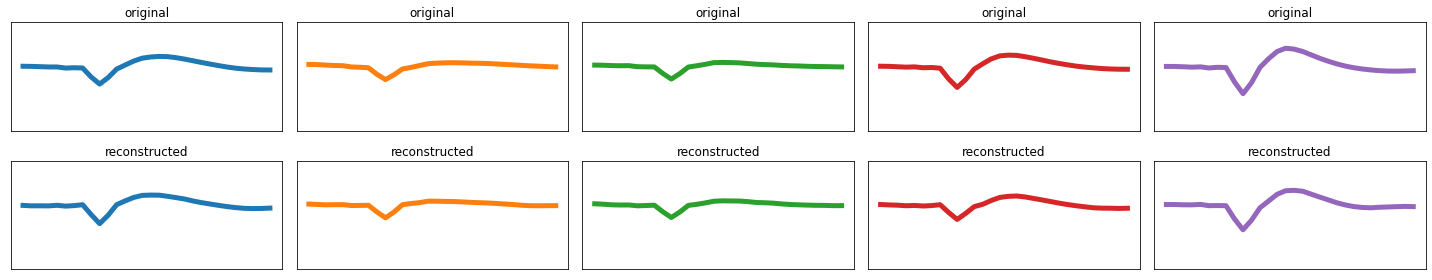

In [66]:
plot_average_waveform_reconstructions(autoencoder,
                              X_test_all_spikes, labels_test_all_spikes.astype('int'), channels_test_all_spikes_enc,
                              color_list,
                              False, '')

### Latent space

#### Latent visualization of training data

In [68]:
color_dic = dict([(i, val) for i, val in enumerate(color_list)])

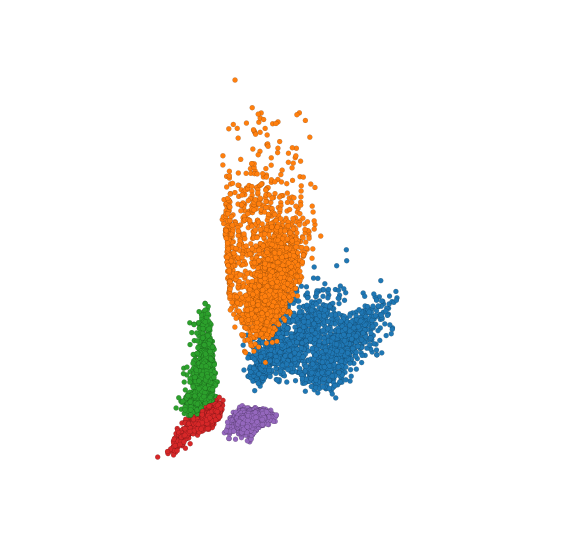

In [69]:
X_z_train = plot_latent_space(encoded_train.numpy(),
                  labels_train,
                  color_dic,
                  'none',
                  False, "",
                  s=25.,
                  lw=0.1,
                  borders=False,
                  xlim=(-10, 15),
                  ylim=(-10, 25),
                  sil_score_show=False)

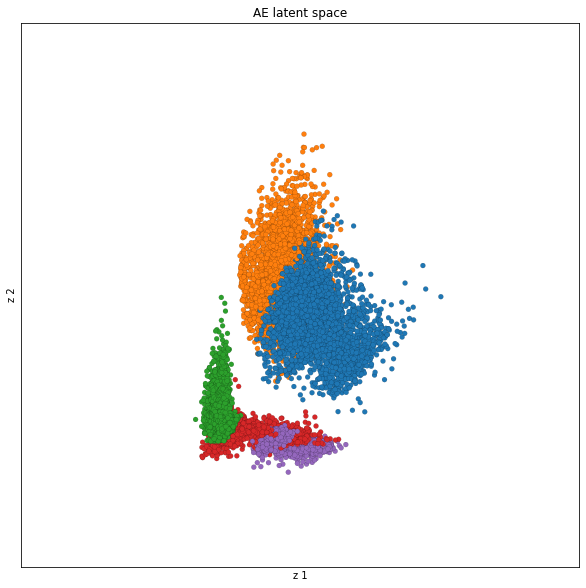

In [70]:
X_z_test_clean = plot_latent_space(encoded_test.numpy(),
                  labels_test,
                  color_dic,
                  'none',
                  False,
                  "",
                  s=25.,
                  xlim=(-10, 15),
                  ylim=(-10, 25),
                  lw=0.1,
                  sil_score_show=False)

processing channel 27.0
sil score 0.44737828


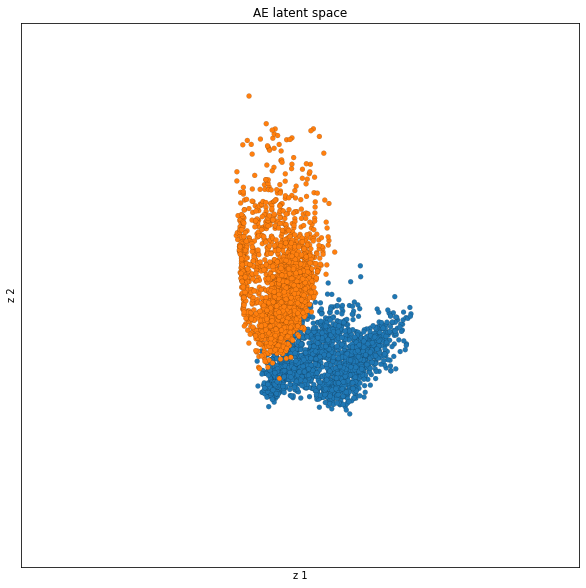

processing channel 19.0


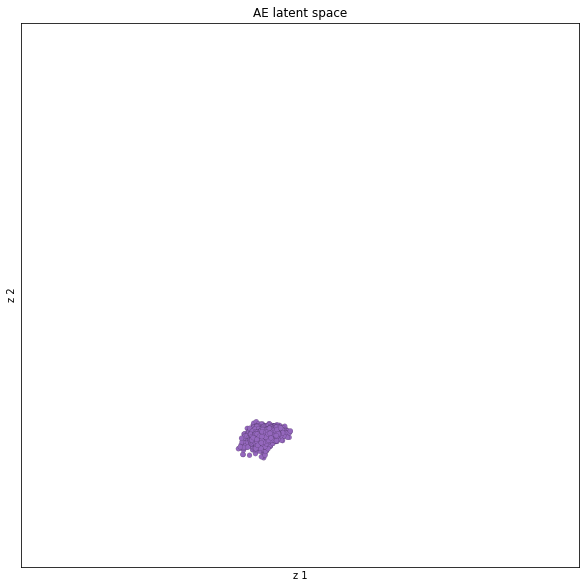

processing channel 21.0
sil score 0.42476118


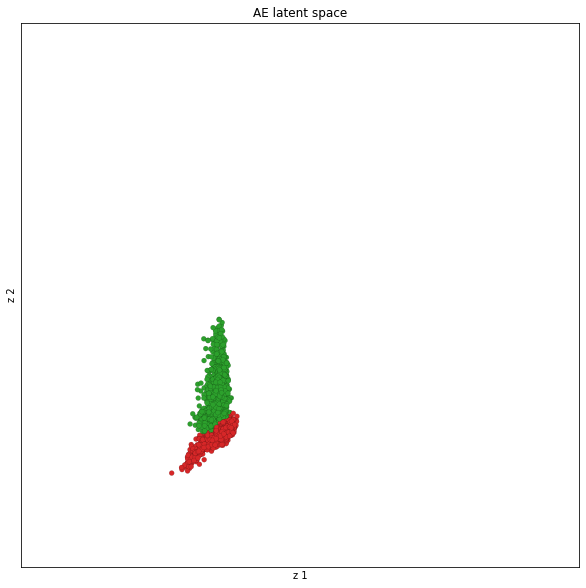

In [71]:
sil_scores_train = []
channels_train_sil_score = []

for channel in df_train['channel'].unique():
  print('processing channel '+str(channel))
  mask = df_train['channel'] == channel
  labels_ = labels_train[mask]
  encoded_ = encoded_train.numpy()[mask]
  if len(np.unique(labels_)) > 1:
    X_, sil_score_ = plot_latent_space(encoded_,
                                labels_,
                                color_dic,
                                'none',
                                False,
                                xlim=(-10, 15),
                                ylim=(-10, 25),
                                savefig_path=f'',
                                title=f'',
                          sil_score_show=True,
                          s=25.,
                          lw=0.1,)
    sil_scores_train.append(sil_score_)
    channels_train_sil_score.append(channel)
  else:
    X_ = plot_latent_space(encoded_,
                                labels_,
                                color_dic,
                                'none',
                                False,
                                xlim=(-10, 15),
                                ylim=(-10, 25),
                                savefig_path=f'',
                                title=f'',
                          sil_score_show=True,
                          s=25.,
                          lw=0.1,)
  

#### Latent visualization on noisy test data

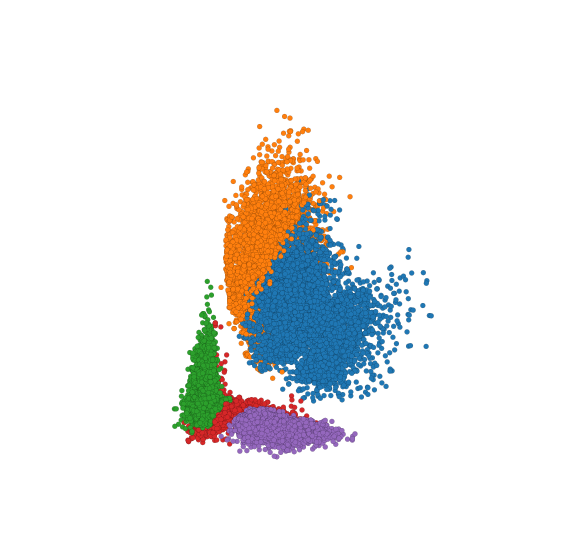

In [72]:
X_z = plot_latent_space(encoded_test_all_spikes.numpy(),
                  labels_test_all_spikes,
                  color_dic,
                  'none',
                  False, "",
                  sil_score_show=False,
                  borders=False,
                  s=25.,
                  xlim=(-10, 15),
                  ylim=(-10, 25),
                  lw=0.1)

processing channel 0
sil score 0.21755715


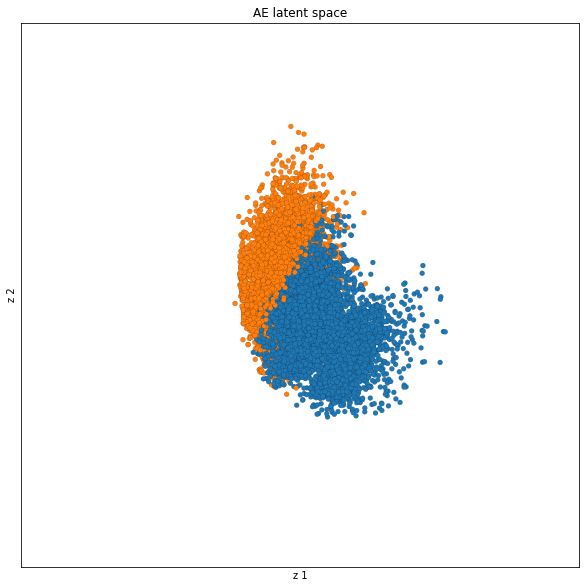

processing channel 1


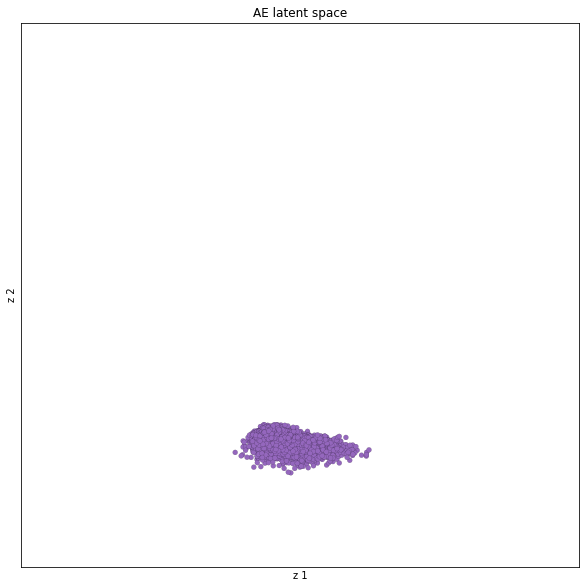

processing channel 2
sil score 0.24254905


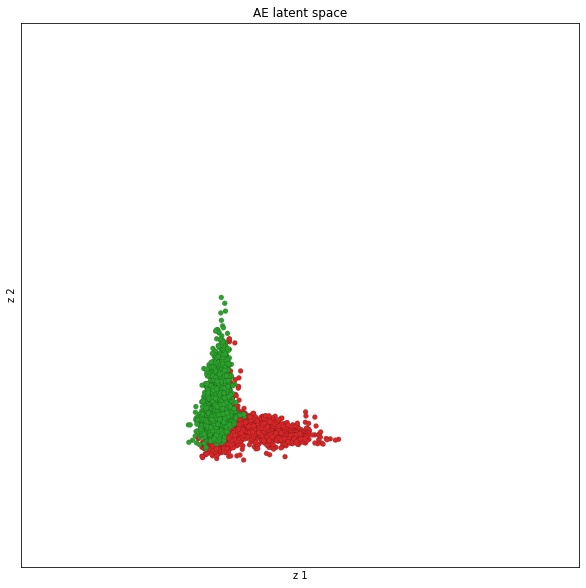

In [73]:
sil_scores_test = []
channels_test_sil_score = []

for channel in np.unique(channels_test_all_spikes):
  print('processing channel '+str(channel))
  mask = channels_test_all_spikes == channel
  labels_ = labels_test_all_spikes[mask]
  encoded_ = encoded_test_all_spikes.numpy()[mask]
  if len(np.unique(labels_)) > 1:
    X_, sil_score_ = plot_latent_space(encoded_,
                                labels_,
                                color_dic,
                                'none',
                                False,
                                f'',
                                title=f'',
                                sil_score_show=True,
                                xlim=(-10, 15),
                                 ylim=(-10, 25),
                                lw=.1,
                                s=25.)
    sil_scores_test.append(sil_score_)
    channels_test_sil_score.append(channel)
  else:
    X_  = plot_latent_space(encoded_,
                              labels_,
                              color_dic,
                              'none',
                              False,
                              f'',
                              title=f'',
                              sil_score_show=False,
                              xlim=(-10, 15),
                                ylim=(-10, 25),
                              lw=.1,
                              s=25.)

In [74]:
color_list2 = sns.color_palette('tab10')
color_dic2 = dict([(i, val) for i, val in enumerate(color_list2)])

sil score 0.015319459


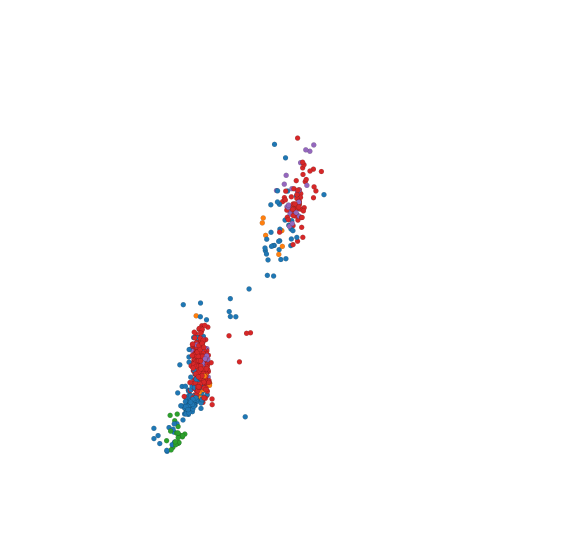

In [96]:
X_z_anomaly, sil_score_anomaly = plot_latent_space(encoded_anomaly.numpy(),
                  labels_anomaly,
                  color_dic2,
                  'none',
                  False, "",
                  lw=0.1,
                  s=25.,
                  xlim=(-10, 15),
                  ylim=(-10, 25),
                  figsize=(10, 10),
                  borders=False,
                  sil_score_show=True)

In [76]:
from scipy.spatial import ConvexHull

In [77]:
from descartes import PolygonPatch
import alphashape

In [78]:
hull_train = ConvexHull(encoded_train.numpy(), incremental=True)
hull_anomaly = ConvexHull(encoded_anomaly.numpy(), incremental=True)

In [79]:
alpha_shape_train = alphashape.alphashape(encoded_train.numpy(), 0.1)
alpha_shape_anomaly = alphashape.alphashape(encoded_anomaly.numpy(), 0.1)

In [80]:
from mpl_toolkits import mplot3d

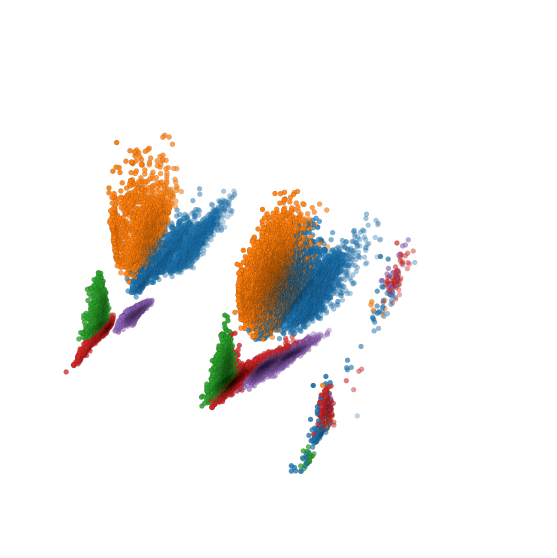

In [81]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection="3d")


ax.scatter(np.ones(encoded_test_all_spikes.numpy().shape[0])+0.5, encoded_test_all_spikes.numpy()[:, 0], 
           encoded_test_all_spikes.numpy()[:, 1], c=list(map(color_dic.get, labels_test_all_spikes)), s=25., lw=0.1, edgecolor='black')

ax.scatter(np.ones(encoded_train.numpy().shape[0]), encoded_train.numpy()[:, 0], 
           encoded_train.numpy()[:, 1], c=list(map(color_dic.get, labels_train)), s=25., lw=0.1, edgecolor='black')

ax.scatter(np.ones(encoded_anomaly.numpy().shape[0])+.9, encoded_anomaly.numpy()[:, 0], 
           encoded_anomaly.numpy()[:, 1], c=list(map(color_dic2.get, labels_anomaly)), s=25., lw=0.1, edgecolor='black')

ax.azim = -50
ax.set_xlim(1, 2)
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.set_axis_off()
plt.show()

In [82]:
def in_hull(p, hull):
    """
    Test if points in `p` are in `hull`

    `p` should be a `NxK` coordinates of `N` points in `K` dimensions
    `hull` is either a scipy.spatial.Delaunay object or the `MxK` array of the 
    coordinates of `M` points in `K`dimensions for which Delaunay triangulation
    will be computed
    """
    from scipy.spatial import Delaunay
    if not isinstance(hull, Delaunay):
        hull = Delaunay(hull.points)

    return hull.find_simplex(p)>=0

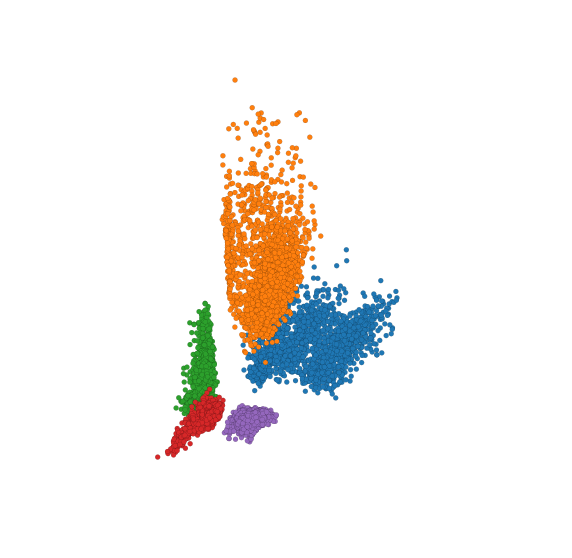

In [90]:
#get convex hull of each training neuron clust
convex_hulls_training = []
polygons = []

fig, ax = plt.subplots(figsize=(10, 10))

for i, neuron in enumerate(sorted(np.unique(labels_train))):
  mask = labels_train == neuron 
  X_train_ = encoded_train.numpy()[mask]
  hull_ =  ConvexHull(X_train_, incremental=True)
  convex_hulls_training.append(hull_)
  ax.scatter(X_train_[:, 0], X_train_[:, 1], c=list(map(color_dic.get,
                                                        labels_train[mask])),
             s=25., lw=.1, edgecolor='black')
  poly_ = plt.Polygon(X_train_[hull_.vertices, :], fc=None, ec=color_dic[neuron],
                           linewidth=3., fill=False, linestyle='--')
  #ax.add_patch(poly_)
  polygons.append(poly_)

ax.set_xticks([])
ax.set_yticks([])
ax.set_xlim((-10, 15))
ax.set_ylim((-10, 25))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

#plt.savefig('./results/AE_dense_classifier/train_latent_space_boundaries_no_borders_scale_mouse2.pdf')
plt.show()

In [84]:
#add processing for each predicted neuron in noisy dataset
X_test_no_noise = []
channel_test_no_noise = []
spikes_test_no_noise = []
labels_test_no_noise = []
real_labels_test_no_noise = []

X_test_rejected = []
channels_test_rejected = []
spikes_test_rejected = []
labels_test_rejected = []
real_labels_test_rejected = []

for i, neuron in enumerate(sorted(np.unique(y_pred_test_all))):
  mask1 = y_pred_test_all == neuron
  #make sure only one channel is used for a given neuron
  channel_ = np.array(channels_test_all_spikes)[mask1]
  values, channel_counts = np.unique(channel_, return_counts=True)
  print(np.unique(channel_)[np.argmax(channel_counts)])
  max_chan = np.unique(channel_)[np.argmax(channel_counts)]
  mask2 = np.array(channels_test_all_spikes) == max_chan
  mask = mask1 & mask2
  #current
  channel_ = np.array(channels_test_all_spikes)[mask]
  X_test_ = encoded_test_all_spikes.numpy()[mask]
  y_pred_ = y_pred_test_all[mask]
  spikes_ = X_test_all_spikes[mask]
  labels_test_ = labels_test_all_spikes[mask]
  #keep rejected
  channels_test_rejected.append(np.array(channels_test_all_spikes)[mask1&~mask2])
  labels_test_rejected.append(y_pred_test_all[mask1&~mask2])
  real_labels_test_rejected.append(labels_test_all_spikes[mask1&~mask2])
  spikes_test_rejected.append(X_test_all_spikes[mask1&~mask2])
  X_test_rejected.append(encoded_test_all_spikes.numpy()[mask1&~mask2])
  #rejection
  new_mask = in_hull(X_test_, convex_hulls_training[i])
  X_test_no_noise.append(X_test_[new_mask])
  #append
  channel_test_no_noise.append(channel_[new_mask])
  labels_test_no_noise.append(y_pred_[new_mask])
  real_labels_test_no_noise.append(labels_test_[new_mask])
  spikes_test_no_noise.append(spikes_[new_mask])

  X_test_rejected.append(X_test_[~new_mask])
  channels_test_rejected.append(channel_[~new_mask])
  labels_test_rejected.append(y_pred_[~new_mask])
  real_labels_test_rejected.append(labels_test_[~new_mask])
  spikes_test_rejected.append(spikes_[~new_mask])

0
0
2
2
1


In [85]:
X_test_no_noise = np.vstack(X_test_no_noise)
channel_test_no_noise = np.hstack(channel_test_no_noise)
labels_test_no_noise = np.hstack(labels_test_no_noise)
real_labels_test_no_noise = np.hstack(real_labels_test_no_noise)
spikes_test_no_noise = np.vstack(spikes_test_no_noise)

In [86]:
X_test_rejected = np.vstack(X_test_rejected)
channels_test_rejected = np.hstack(channels_test_rejected)
labels_test_rejected = np.hstack(labels_test_rejected)
real_labels_test_rejected = np.hstack(real_labels_test_rejected)
spikes_test_rejected = np.vstack(spikes_test_rejected)

In [87]:
xlims = []
ylims = []

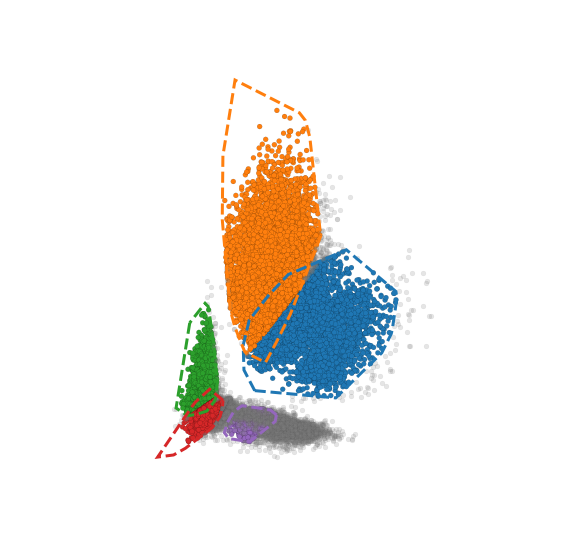

In [91]:
fig, ax = plt.subplots(figsize=(10, 10))

for i, channel in enumerate(np.unique(channel_test_no_noise)):
  mask = np.array(channel_test_no_noise) == channel
  mask_noise = np.array(channels_test_rejected) == channel
  X_ = X_test_no_noise[mask]
  X_rejected_ = X_test_rejected[mask_noise]
  neurons_ = np.unique(labels_test_no_noise[mask])
  ax.scatter(X_[:, 0], X_[:, 1],
               s=25., lw=0.1, c=list(map(color_dic.get, labels_test_no_noise[mask])),
               edgecolor='black')
  ax.scatter(X_rejected_[:, 0], X_rejected_[:, 1],
               s=25., lw=0.1, color='grey', alpha=0.2,
               edgecolor='black')
  for n in neurons_:
    ax.add_patch(polygons[n])
  # ax.set_xlabel('z1')
  # ax.set_ylabel('z2')
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlim((-10, 15))
ax.set_ylim((-10, 25))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.show()

In [92]:
rejection_probs = []
labels_rejection = []
counts_no_noise = []
counts_rejected = []
for label in np.unique(labels_test_no_noise):
  sum_labels_no_noise = np.sum(labels_test_no_noise == label)
  sum_labels_noise = np.sum(labels_test_rejected == label)
  rejection_probs.append(sum_labels_noise/(sum_labels_noise+sum_labels_no_noise))
  labels_rejection.append(label)
  counts_no_noise.append(sum_labels_no_noise)
  counts_rejected.append(sum_labels_noise)

In [93]:
df_rejection = pd.DataFrame(rejection_probs, columns=['Percentage_noise'])
df_rejection['count_normal'] = counts_no_noise
df_rejection['count_noise'] = counts_rejected
df_rejection['label'] =  labels_rejection
df_rejection['mouse'] = 2

In [ ]:
#df_rejection.to_csv('')

#### Latent space metrics

In [97]:
sil_scores_train, sil_scores_test, sil_score_anomaly

([0.44737828, 0.42476118], [0.21755715, 0.24254905], 0.015319459)

In [98]:
list_sil_scores = sil_scores_train+sil_scores_test+[sil_score_anomaly]

In [99]:
list_dataset_type = ['train' for _ in sil_scores_train]+['test' for _ in sil_scores_test]+['anomaly']

df_sil_score = pd.DataFrame(list_sil_scores, columns=['silhouette_score'])
df_sil_score['dataset_type'] = list_dataset_type
df_sil_score['mouse'] = 2

<AxesSubplot:xlabel='dataset_type', ylabel='silhouette_score'>

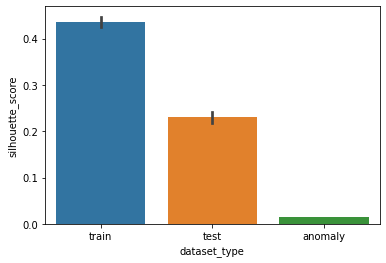

In [100]:
sns.barplot(x='dataset_type', y='silhouette_score', data=df_sil_score)
#plt.savefig('./results/AE_dense_classifier/sil_score_final_mouse2.pdf')

In [ ]:
#df_sil_score.to_csv('./results/AE_dense_classifier/sil_scores_data_mouse2.csv')

## Using MSE for anomaly detection

In [101]:
mse_train = ((decoded_train.numpy() - X_train)**2).mean(axis=1)
mse_test = ((decoded_test.numpy() - X_test)**2).mean(axis=1)
mse_test_noisy = ((decoded_test_all.numpy() - X_test_all_spikes)**2).mean(axis=1)
mse_anomaly = ((decoded_anomaly.numpy() - X_anomaly)**2).mean(axis=1)

In [102]:
threshold = np.mean(mse_train) + 2*np.std(mse_train)

In [103]:
threshold

192.55757325416894

In [104]:
df_plot1 = pd.DataFrame(np.hstack([mse_train, mse_test_noisy, mse_anomaly]), columns=['mse'])
df_plot1['type'] = np.hstack([['train' for _ in range(len(mse_train))],
                        ['test' for _ in range(len(mse_test_noisy))],
                        ['anomaly' for _ in range(len(mse_anomaly))]])
df_plot1['mouse'] = 2

In [ ]:
#df_plot1.to_csv('')

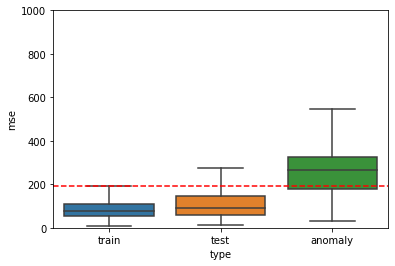

In [105]:
ax = sns.boxplot(x="type", y="mse", data=df_plot1, fliersize=0.)
ax.set_ylim((0, 1000))
plt.axhline(threshold, c='r', linestyle='--')
#plt.savefig('./results/AE_dense_classifier/mse_anomaly_detection_mouse2.pdf')
plt.show()